##Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

# 1. Authorizing google colab
from google.colab import auth
auth.authenticate_user()

# 2. credentials for google sheets
import gspread
from google.auth import default
creds, _ = default()

# 3. authotizing the connection
gc = gspread.authorize(creds)

Mounted at /content/drive


##import

In [ ]:
#https://towardsdatascience.com/particle-swarm-optimization-visually-explained-46289eeb2e14
#https://ieeexplore.ieee.org/document/6256112
#https://web.archive.org/web/20030503203304/http://antho.huntingdon.edu/publications/Off-The-Shelf_PSO.pdf

import random

import numpy as np
import pandas as pd

from time import sleep
from datetime import datetime

#import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)


##path and parameters

In [ ]:
#path = "/content/drive/MyDrive/PNaF/Diamentowy_Grant_2017-2021/Swimming_caterpillars_evolution/wyniki/"
#backup_path = "/content/drive/MyDrive/PNaF/Diamentowy_Grant_2017-2021/Swimming_caterpillars_evolution/wyniki/backup/"

In [ ]:
#@title parameters
archive_googlesheet_ID = '1WyDXV6AXQGRs0PPzMrzQXm7jdKMCH8bVGBvha97zf1k'
result_googlesheet_ID = '1UZPpqPW_zMDl1-P3JSCb5iJff2AFJYW_6oH8YSzCbgc'
results_sheet_1 = 'PSO_1'
#default_save_path = "/content/drive/MyDrive/"
backup_path = "/content/drive/MyDrive/PNaF/Diamentowy_Grant_2017-2021/Swimming_caterpillars_evolution/wyniki/backup/"

parameters_names = ['frequency [Hz]', 'length [mm]', 'dye [%mol]', 'thickness [µm]', 'alignment period [mm]',
             'laser power [W]', 'right side [down 0, up 1]', 'waveplate angle [deg]']

PSO_velocity = ['parameter {} velocity'.format(i+1) for i in range(len(parameters_names))]

fitness_names = ['fitness function \n(max average)', 'best fitness function']

individuals_no = 8
iteration_max = 5

frequency_list = [float(i)/10. for i in range(1,51)]
length_list = [6,12,18]
dye_list = [0.2,1]
thickness_list = [50,90]
period_list = [1,2,3]
laserPower_list = [float(i)/2. for i in range(1,9)]
waveplate_list = [7.5*int(i)+30 for i in range(0,12)]
# right side of the film 0 down, 1 up
tail_list = [0,1]
parameters_list = [frequency_list, length_list, dye_list, thickness_list,
                   period_list, laserPower_list, tail_list, waveplate_list]

c0_global = 0. # 0.4
c1_global = 0.2 # 2.5
c2_global = 2.2 # 0.5


# #do testów
# # 14 400 possibilities
# frequency_list = [float(i)/10. for i in range(1,51)]
# length_list = [6,12,18]
# dye_list = [0.2,1]
# thickness_list = [50,90]
# period_list = [1,2,3]
# laserPower_list = [float(i)/2. for i in range(1,9)]
# waveplate_list = [5*int(i)+30 for i in range(0,18)]
# # right side of the film 0 down, 1 up
# tail_list = [0,1]

# #test
# frequency_list = [float(i) for i in range(0,120)]
# laserPower_list = [float(i) for i in range(0,120)]


# parameters_list = [frequency_list, length_list, dye_list, thickness_list,
#                    period_list, laserPower_list, tail_list, waveplate_list]


# Przetestowane funkcje

Zmiany względem wersji 1 to brak zmiennej oznaczającej maksymalną liczbę iteracji.

- get_single_sheet_by_name_dataframe(workbook, str:sheet_name) - zwraca dataframe z zawartością arkusza o nazwie `sheet_name` z workbook'a `workbook`. Nazwy wierszy zwracanego dataframe'a to pierwsza kolumna arkusza.

- get_single_sheet_by_number_dataframe(workbook, int:sheet_no) - zwraca dataframe z zawartością arkusza nr `sheet_no` z workbook'a `workbook`. Nazwy wierszy zwracanego dataframe'a to pierwsza kolumna arkusza.

- get_googlesheet_by_name_dataframe(str:googlesheet_ID, str:sheet_name = 'results') - zwraca dataframe z zawartością arkusza o nazwie `sheet_name` z googlesheet'a `googlesheet_ID`. Nazwy wierszy zwracanego dataframe'a to pierwsza kolumna arkusza.

- merge_dataframes_list(list:dataframes_list) - zwraca dataframe będący połączeniem wszystkich dataframe'ów na liście `dataframes_list`.

- write_dataframe_to_googlesheet(dataframe:dataframe, str:googlesheet_ID, str:sheet_name, bool:row_names = True, bool:column_names = False) - zapisuje dataframe `dataframe` w arkuszu o nazwie `sheet_name` w googlesheet'cie `googlesheet_ID`. Jeśli `row_names` dopisuje nazwy wierszy jako pierwszą kolumnę, jeśli `column_names` dopisuje nazwy kolumn jako pierwszy wiersz.
<br> Jak wywołałem:
<br> dataframes_list = get_all_sheets_from_googlesheet_dataframeList('1eM20dajVdOGcK_AZXDsj8ayzoPTjcRS65_LvrTfDPDI')
<br> merged = merge_dataframes_list(dataframes_list)
<br> write_dataframe_to_googlesheet(merged, '1eM20dajVdOGcK_AZXDsj8ayzoPTjcRS65_LvrTfDPDI', 'test')
<br> pojawił się komunikat:
<br> <ipython-input-5-abe2251829ad>:157: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()` data.insert(0, '0', data.index, True).

- get_all_sheets_from_googlesheet_dataframeList(googlesheet_ID) - zwraca listę dataframe'ów, których zawartością jest treść kolejnych arkuszy googlesheet'a `googlesheet_ID`.

- get_txt_by_path_list(str:path) - zwraca listę, której elementami są kolejne linijki tekstu pliku txt z lokalizacji `path`.

- dataframe_to_caterpillars_list(dataframe:dataframe) - zmienia dataframe `dataframe` na listę obiektów klasy `caterpilar`.

- get_best_caterpillar(list:caterpillars_list) - spośród obiektów klasy `caterpillar` na liście `caterpillars_list` zwraca osobnika z najwyższym parametrem `fitness_best`.

- get_parameters_indexes_dictionary(dataframe: dataframe) - zwraca słownik z numerami index'ów zmiennej `dataframe` pod którymi są po kolei: pierwszy parametr bierzącej iteracji (klucz `parameters_index`), prędkość PSO dla pierwszego parametru (klucz `velocities_index`), pierwszy parametr najlepszego wyniku (klucz `best_parameters_index`), najwyższe wartości fitness function dla każdego osobnika (klucz `best_fitness_function_index`).

- update_best_parameters(dataframe:last_iteration_dataframe, list:velocities_list, list:best_parameters_list, list:best_fitness_list) - zwraca dataframe, który powstaje poprzez podmianę wartości dataframe `last_iteration_dataframe` na wartości w zmiennych `velocities_list`, `best_parameters_list`, `best_fitness_list`.

- update_caterpillar_list(caterpillars_list, iteration_no, iteration_max) - zwraca listę obiektów klasy `caterpillar` i słownik wartości. Zwracana lista obiektów klasy `caterpillar` to kopie obiektów z listy `caterpillars_list` z wartościami zmiennych `velocities`, `parameters_best` i `fitness_best`  zaktualizowanymi na podstawie swoich parametrów i argumentów `iteration_no` (nr obecnej iteracji) i `iteration_max` (maksymalna liczba iteracji). Zwracany słownik zawiera listy wartości parametru `velocities` (klucz `velocities_list`), parametru `parameters_best` (klucz `best_parameters_list`) i parametru `fitness_best` (klucz `best_fitness_list`) obiektów ze zwracanej listy.

- add_empty_column_to_dataframe(dataframe:dataframe) - zwraca dataframe otrzymany poprzez dodanie pustej kolumny do zmiennej `dataframe`.

- get_new_iteration_caterpillar(list:caterpillars_list, int:iteration_no, int:iteration_max) - zwraca listę obiektów klasy `caterpillar`, które powstają poprzez obliczenie nowych parametró dla każdego obiektu klasy `caterpilar` z listy `caterpillars_list` zgodnie z algorytmem PSO, na podstawie prędkości w przestrzeni parametrycznej obiektów na liście (zmienna `velocities` klasy `caterpillar`).

- caterpillars_list_to_dataframe(list:caterpillars_list, dictionary:indexes_dictionary) - zwraca dataframe zawierający parametry obiektów klasy `caterpillar` z listy `caterpillars_list` w miejscach zdefiniowanych przez zmienną `indexes_dictionary`.

- append_caterpillars_list_to_dataframe(dataframe:dataframe, list:caterpillars_list) - zwraca dataframe, który powstaje poprzez dodanie parametrów obiektów klasy `caterpillar` z listy `caterpillars_list` na końcu zmiennej `dataframe`.

- remove_dataframe_duplicates(dataframe:dataframe, bool:make_index = False) - zwraca dataframe otrzymany poprzez usunięcie duplikatów kolumn z argumentu `dataframe`. Jeśli `make_index` nazwie wiersze zwracanego dataframe używając pierwszej kolumny zmiennej `dataframe`

- overwrite_googlesheet_by_dataframe(dataframe:dataframe, str:googlesheet_ID, str:sheet_name, bool:row_names = True, bool:column_names = False) - nadpisuje arkusz `sheet_name` w google sheet `googlesheet_ID` wartościami zmiennej `dataframe`. Jeśli `row_names` pierwszą kolumną będą nazwy wierszy, jeśli `column_names` pierwszym wierszem będą nazwy kolumn.

- make_dataframe_backup(dataframe:dataframe, str:backup_name, str:backup_path, bool:row_names = True) - tworzy googlesheet'a o nazwie zawierającej `backup_name` i aktualną datę i godzinę (z dokładnością do sekund) w lokalizacji `backup_path`, którego zawartością jest `dataframe`. Jeśli `row_names` pierwszą kolumną w utworzonym pliku są nazwy wierszy argumentu `dataframe`.

- make_archive_backup(str:archive_googlesheet_ID, str:backup_path) - tworzy kopię googlesheet'a `archive_googlesheet_ID` w lokalizacji `backup_path` pod nazwą archiive_aktualnadata_aktualnagodzina.

- create_archive() - tworzy googlesheet'a o nazwie 'archive', którego zawartością są wszystkie arkusze wyników optymalizacji algorytmem genetycznym.

- add_results_to_archive_and_remove_duplicates(dataframe:results_new, str:archive_googlesheet_ID) - dodaje dataframe `results_new` do googlesheet'a `archive_googlesheet_ID` z archiwum wyników. Automatycznie usuwa duplikaty, zwraca dataframe ze zaktualizowanym archiwum wyników.

- update_archive(dataframe:results_dataframe, str:archive_googlesheet_ID, str:backup_path) - tworzy backup archiwum wyników z arkusza `archive_googlesheet_ID`, dodaje `results_dataframe` i usuwa duplikaty z archiwum. Zwraca dataframe ze zaktualizowanym archiwum wyników.

- fill_dataframe_with_results_from_archive(dataframe:results_dataframe, dataframe:archive_dataframe) - zwraca dataframe'a, który powstaje poprzez uzupełnienie dataframe'a `results_dataframe` wynikami zawartymi w `archive_dataframe` (jeśli takie istnieją).

- save_new_iteration(dataframe:results_dataframe, dictionary:iteration_parameters, list:caterpillars_list_new, srt:googlesheet_ID, srt:sheet_name) - uzupełnia dataframe `results_dataframe` parametrami ze słownika `iteration_parameters`, dodaje do dataframe'a parametry z listy obiektów klasy `caterpillar`. Robi backup archiwum, dopisuje nowe wyniki do archiwum i nadpisuje arkusz `sheet_name` z googlesheet'a `googlesheet_ID` zaktualizowanym dataframe'm.

- PSO_step(googlesheet_ID, sheet_name, iteration_no, iteration_max) - aktualizuje parametry, generuje i dopisuje nową iterację w arkuszu `sheet_name` googlesheet'a `googlesheet_ID` na podstawie wartości argumentów `iteration_no` i `iteration_max`. Tworzy backup archiwum, zapisuje w archiwum nowe wyniki.

- new_generation() - zwraca listę nowych obiektów klasy `caterpillar` z losowymi parametrami. Długość listy określa zmienna globalna `individuals_no`.

- find_index(index_name) - zwraca nr indeksu listy `parameters_names` na którym znajduje się element zawierający zmienną string `index_name`.

- waveplate_periodic_boundary_conditions(parameters) - zwraca listę parametrów z podmienionym parametrem odpowiadającym kątowi ustawienia półfalówki

Nieużywane:

- remove_duplicates_from_archive() - usuwa duplikaty kolumn z googlesheeta z archiwum wyników.

- add_results_to_archive(dataframe:results_new) - dodaje dataframe `results_new` do googlesheeta z archiwum wyników. Automatycznie usuwa duplikaty.

- get_parameters_indexes(dataframe: dataframe) - zwraca numery index'ów zmiennej `dataframe` pod którymi są po kolei: pierwszy parametr bierzącej iteracji, prędkość PSO dla pierwszego parametru, pierwszy parametr najlepszego wyniku, oba wiersze z przeliczonym kątem półfalówki, najwyższe wartości fitness function dla każdego osobnika.

- get_last_iteration_dataframe(str:googlesheet_ID, str:sheet_name) - zwraca dataframe z ostatnią zmierzoną iteracją zapisaną w arkuszu `sheet_name` w googlesheet'cie `googlesheet_ID`.

- update_last_iteration_dataframe(dataframe:dataframe, int:iteration_no, int:iteration_max) - zwraca dataframe i listę obiektów klasy `caterpillar` z przeliczonymi prędkościami PSO w przestrzeni parametrów i najwyższymi wartościami parametrów. `iteration_no` to nr obecnej iteracji, a `iteration_max` to maksymalna liczba iteracji w eksperymencie, czyli zmienne na podstawie których obliczane są parametry PSO.

- caterpillars_list_to_lists(caterpillars_list) - zwraca listy zawierające parametry obiektów klasy `caterpillar` z listy `caterpillars_list`
zwraca dataframe zawierający parametry obiektów klasy `caterpillar` z listy `caterpillars_list` w miejscach zdefiniowanych przez zmienną `indexes_dictionary`. Listy zawierają kolejno: wartości zmiennej `parameters`, wartości zmiennej `velocities`, wartości zmiennej `parameters_best`, wartości zmiennej `fitness_best`.


# PLAN

gotowe:
- make_archive_backup
- add_results_to_archive

https://www.sciencedirect.com/science/article/abs/pii/S0377221712007667?via%3Dihub publikacja ze zmianą bezwładności
https://towardsdatascience.com/ artykuł o PSO particle-swarm-optimization-visually-explained-46289eeb2e14
append_columns_to_worksheet(path, sheet_name/sheet_nr, columns_list)
https://docs.gspread.org/en/latest/user-guide.html

- [x] dopisywanie nowych wyników do archiwum
- [x] backup archiwum po każdej generacji kroku z datą i godziną
- [x] nowa klasa z dodatkowymi parametrami (prędkościami)
- [x] generowanie następnej iteracji
- [x] sprawdzanie czy parametry są już zmierzone
- [x] zapis nowego kroku do googlesheet
- [x] funkcja dodające kolumny na końcu (dataframe)
- [ ] rysowanie wykresów średnia, najszybszy itd.
- [ ] rysowanie każdego kroku dla wybranej pary parametrów

# definicje

In [ ]:
#@title definitions

#działa, opisana
def get_single_sheet_by_name_dataframe(workbook, sheet_name):
    worksheet = workbook.worksheet(sheet_name)
    rows = worksheet.get_all_values()
    df = pd.DataFrame(rows)
    df.index = df.copy()[0]
    df = df[df.columns[1:]]
    return df.copy()

#działa, opisana
def get_single_sheet_by_number_dataframe(workbook, sheet_no):
    worksheet = workbook.get_worksheet(sheet_no)
    rows = worksheet.get_all_values()
    df = pd.DataFrame(rows)
    df.index = df.copy()[0]
    df = df[df.columns[1:]]
    return df.copy()

#działa, opisana
def get_googlesheet_by_name_dataframe(googlesheet_ID, sheet_name = 'results'):
    workbook = gc.open_by_key(googlesheet_ID)
    worksheet = workbook.worksheet(sheet_name)
    rows = worksheet.get_all_values()
    df = pd.DataFrame(rows)
    df.index = df.copy()[0]
    df = df[df.columns[1:]]
    return df.copy()

#działa, opisana
def merge_dataframes_list(dataframes_list):
    dataframes_no = len(dataframes_list)
    merged_dataframe = dataframes_list[0]
    index = list(merged_dataframe.index.values)
    merged_dataframe = merged_dataframe.reset_index(drop=True)
    for i in range(dataframes_no-1):
        #merged_dataframe = pd.concat([merged_dataframe, dataframes_list[i+1]], axis=1)
        merged_dataframe = pd.concat([merged_dataframe, dataframes_list[i+1].reset_index(drop=True)], axis=1, ignore_index=True)
    for i in range(len(index)):
        merged_dataframe.rename(index={list(merged_dataframe.index.values)[i]:index[i]},inplace=True)
    return merged_dataframe.copy()

#działa, opisana
def write_dataframe_to_googlesheet(dataframe, googlesheet_ID, sheet_name, row_names = True, column_names = False):
    data = dataframe.copy().fillna('')
    #dataframe = dataframe.fillna(0, inplace=True)
    if (row_names):
        data.insert(0, '0', data.index, True)
    if (column_names):
        column_names_list = data.columns.to_list()
        data = data.to_numpy().tolist()
        all_data = [column_names_list] + data
    else:
        all_data = data.to_numpy().tolist()
    workbook = gc.open_by_key(googlesheet_ID)
    worksheet = workbook.worksheet(sheet_name)
    worksheet.update(None,all_data)
    return

#działa, opisana
def get_all_sheets_from_googlesheet_dataframeList(googlesheet_ID):
    workbook = gc.open_by_key(googlesheet_ID)
    df = []
    sheets_no = len(workbook.worksheets())
    for i in range(sheets_no):
        df.append(get_single_sheet_by_number_dataframe(workbook, i).copy())
    return df

#działa, opisana
def get_txt_by_path_list(path):
    with open(path, "r") as f:
        previous_results = f.readlines()
    return previous_results

#działa, opisana
def find_index(index_name):
    for i, name in enumerate(parameters_names):
        if index_name in name:
            return i
    print("No index found")
    return

#działa, opisana
def waveplate_periodic_boundary_conditions(parameters):
    i = find_index("waveplate")
    waveplate = parameters[i]
    waveplate_list = parameters_list[i]
    delta = abs(waveplate_list[1] - waveplate_list[0])
    waveplate_floor = np.floor(waveplate/delta)

    if 2*(waveplate - waveplate_floor*delta) >= delta:
        waveplate = (waveplate_floor+1) * delta
    else:
        waveplate = waveplate_floor * delta
    if abs(waveplate - min(waveplate_list)) < delta/3.:
        waveplate = min(waveplate_list)
    elif abs(waveplate - max(waveplate_list)) < delta/3.:
        waveplate = max(waveplate_list)

    while waveplate > max(waveplate_list):
        waveplate -= (max(waveplate_list) - min(waveplate_list))
    while waveplate < min(waveplate_list):
        waveplate += (max(waveplate_list) - min(waveplate_list))

    param = np.copy(parameters)
    param[i] = waveplate
    return param

class caterpillar:
    #names = ["frequency", "length", "dye", "thickness", "period", "laserPower", "tail", "waveplate"]
    #global variables
    parameters = parameters_best = velocities = [0 for i in range (0, len(parameters_names))]
    fitness = fitness_best = 0

    def __init__(self, param = [''], f = -1, v = [''], p_best = [''], f_best = -1):
        self.fitness = f

        if '' in param:
            self.parameters = self.parameters_best = np.array([random.choice(parameters_list[i]) for i in range(0, len(parameters_names))])
            self.velocities = [0. for i in range(0, len(parameters_names))]
            #self.parameters = np.copy(self.parameters)
            #self.velocities = np.copy(self.velocities)
            self.parameters_best = np.copy(self.parameters_best)

        else:
            if f == '':
                f_new = -1
            else:
                f_new = f

            parameters = np.array(param).astype(float)
            self.parameters = np.copy(np.array(param).astype(float))
            if '' in v:
                self.velocities = np.copy(np.array([v]))
            else:
                self.velocities = np.copy(np.array(v).astype(float))
            f_float = float(f_new)
            f_best_float = float(f_best)
            if f_float > f_best_float or f_best_float == -1.:
                self.parameters_best = np.copy(parameters)
                self.fitness_best = f_float
            else:
                self.parameters_best = np.copy(np.array(p_best).astype(float))
                self.fitness_best = f_best_float

    def change_parameters(self, param, f, v, p_best=[''], f_best=-1):
        self.parameters = np.copy(param)
        self.fitness = f
        self.velocities = np.copy(v)

        if type(f_best) == str or f > f_best or f_best == '':
            self.parameters_best = np.copy(param)
            self.fitness_best = f
        else:
            if '' in p_best:
                self.parameters_best = np.copy(param)
                self.fitness_best = f
            else:
                self.parameters_best = np.copy(p_best)
                self.fitness_best = f_best

    def calc_velocities(self, PSO_params, param_best_global, f_global_best, iteration_no, iteration_max):
        # iteration_no_int = int(iteration_no-1)
        # iteration_max_int = int(iteration_max-1)
        w = PSO_params[0]
        c1 = PSO_params[1]
        c2 = PSO_params[2]
        r1 = random.uniform(0, 1)
        r2 = random.uniform(0, 1)
        if '' in self.velocities:
            v = np.array([0 for i in range(len(self.parameters))])
        else:
            v = np.copy(self.velocities)
        if self.fitness == f_global_best:
            v_new = np.array([random.uniform(-0.1, 0.1)*(max(param_list)-min(param_list)) for param_list in parameters_list])
        else:
            v_new = w*v + c1*r1*(self.parameters_best-self.parameters) + c2*r2*(param_best_global-self.parameters)
            waveplate_i = find_index("waveplate")
            for i,vel in enumerate(v_new):
                if i != waveplate_i and vel > max(parameters_list[i])-min(parameters_list[i]):
                    v_new[i] = 0.55*(max(parameters_list[i])-min(parameters_list[i]))
        self.velocities = np.copy(v_new)

    def step(self):
        param = np.copy(self.parameters)
        v = np.copy(self.velocities)
        # p_best = np.copy(self.parameters_best)
        param_new = param + v
        param_new = waveplate_periodic_boundary_conditions(param_new)
        param_new = [min(parameters_list[i], key=lambda x:abs(x-param_new[i])) for i in range (len(parameters_list))]
        self.change_parameters(param_new, -1, v, self.parameters_best, self.fitness_best)

    def print_current_parameters(self):
        parameters_string = ''
        for param in self.parameters:
            parameters_string = parameters_string + str(param) + ' '
        print(parameters_string)
        return

    def print_all_parameters(self):
        parameters_string = 'parameters: '
        for param in self.parameters:
            parameters_string += str(param) + ' '
        parameters_string += '\n'
        parameters_string += 'fitness: '
        parameters_string += str(self.fitness) + '\n'
        parameters_string += 'velocities: '
        for v in self.velocities:
            parameters_string += str(v) + ' '
        parameters_string += '\n'
        parameters_string += 'best parameters: '
        for param in self.parameters_best:
            parameters_string += str(param) + ' '
        parameters_string += '\n'
        parameters_string += 'best fitness: '
        parameters_string += str(self.fitness_best) + ' '
        parameters_string += '\n'
        print(parameters_string)
        return

    def get_copy(self):
        cater = caterpillar(self.parameters, self.fitness, self.velocities, self.parameters_best, self.fitness_best)
        return cater

#działa, opisana
def dataframe_to_caterpillars_list(dataframe):
    df = dataframe.copy().replace(',','.', regex=True)
    caterpillars_list = []
    for column_index in dataframe[df.columns]:
        column = df[column_index]
        parameters = [column[name][0] for name in parameters_names]
        f = column[fitness_names[0]]
        if f != '':
            f = float(f)
        else:
            f = -1
        PSO_v = [column[name] for name in PSO_velocity]
        parameters_best = [column[name][1] for name in parameters_names]
        f_best = column[fitness_names[1]]
        if f_best != '':
            f_best = float(f_best)
        else:
            f_best = -1
        cater = caterpillar(parameters, f, PSO_v, parameters_best, f_best)
        caterpillars_list.append(cater.get_copy())
    return caterpillars_list

#działa, opisana
def get_best_caterpillar(caterpillars_list):
    caterpillar_best = caterpillars_list[0].get_copy()
    for caterpillar in caterpillars_list:
        if caterpillar.fitness_best > caterpillar_best.fitness_best:
            caterpillar_best = caterpillar.get_copy()
    return caterpillar_best

#działa, opisana
def get_parameters_indexes_dictionary(dataframe):
    dataframe_new = dataframe.copy()
    index_list = list(dataframe_new.index)
    velocities_index = index_list.index('parameter 1 velocity')
    parameters_index, best_parameters_index = [i for i, x in enumerate(index_list) if x == parameters_names[0]]
    best_fitness_function_index = [i for i, x in enumerate(index_list) if x == 'best fitness function'][0]
    parameters_indexes_dictionary = {'velocities_index': velocities_index, 'parameters_index': parameters_index, 'best_parameters_index': best_parameters_index, 'best_fitness_function_index': best_fitness_function_index}
    return parameters_indexes_dictionary

#działa, opisana
def update_best_parameters(last_iteration_dataframe, velocities_list, best_parameters_list, best_fitness_list):
    dct = get_parameters_indexes_dictionary(last_iteration_dataframe)
    last_iteration_dataframe_new = last_iteration_dataframe.copy()
    last_iteration_dataframe_new.iloc[dct['velocities_index']:dct['velocities_index']+len(parameters_names),-individuals_no:] = velocities_list
    last_iteration_dataframe_new.iloc[dct['best_parameters_index']:dct['best_parameters_index']+len(parameters_names),-individuals_no:] = best_parameters_list
    last_iteration_dataframe_new.iloc[dct['best_parameters_index']+len(parameters_names),-individuals_no:].fillna(0, inplace=True)
    last_iteration_dataframe_new.iloc[dct['best_parameters_index']+len(parameters_names),-individuals_no:] = last_iteration_dataframe_new.iloc[dct['best_parameters_index']+len(parameters_names)-1,-individuals_no:].astype(float)-30.
    last_iteration_dataframe_new.iloc[dct['best_fitness_function_index'],-individuals_no:] = best_fitness_list
    return last_iteration_dataframe_new

#działa, opisana
def update_caterpillar_list(PSO_params, caterpillars_list, iteration_no, iteration_max):
    caterpillar_list_copy = [cater.get_copy() for cater in caterpillars_list]
    caterpillar_best = get_best_caterpillar(caterpillar_list_copy)
    velocities_list = []
    best_parameters_list = []
    best_fitness_list = []
    for cater in caterpillar_list_copy:
        cater.calc_velocities(PSO_params, caterpillar_best.parameters, caterpillar_best.fitness, iteration_no, iteration_max)
        velocities_list.append(cater.velocities)
        best_parameters_list.append(cater.parameters_best)
        best_fitness_list.append(cater.fitness_best)
    velocities_list = np.array(velocities_list).T
    best_parameters_list = np.array(best_parameters_list).T
    iteration_parameters = {'velocities_list': velocities_list, 'best_parameters_list': best_parameters_list, 'best_fitness_list': best_fitness_list}
    return caterpillar_list_copy, iteration_parameters

#działa, opisana
def add_empty_column_to_dataframe(dataframe):
    dataframe_copy = dataframe.copy()
    columns_no = len(dataframe_copy.columns)
    empty_column = ['' for i in range(len(dataframe_copy))]
    dataframe_copy[str(columns_no)] = empty_column
    return dataframe_copy

#działa, nieopisana
def check_for_duplicates(cater, caterpillars_list):
    duplicate = False
    cater_genes = [round(float(i),1) for i in cater.parameters]
    for c in caterpillars_list:
        c_genes = [round(float(i),1) for i in c.parameters]
        if np.array_equiv(cater_genes, c_genes):
            duplicate = True
    return duplicate

#działa, nieopisana
def single_mutation(cater, mutation_nr):
    genes_list = cater.parameters.copy()
    cater_new = cater.get_copy()
    # draw parameters to mutate
    parameters_indexes = random.sample(range(len(genes_list)), mutation_nr)
    parameters_list_copy = [np.copy(parameters_list[i]) for i in parameters_indexes]
    for i in range(mutation_nr):
        j = parameters_indexes[i]
        parameters_list_copy[i] = np.delete(parameters_list_copy[i], np.where(parameters_list_copy[i] == genes_list[j]))
        genes_list[j] = random.choice(parameters_list_copy[i])
    cater_new.change_parameters(genes_list, cater.fitness, cater.velocities, cater.parameters_best ,cater.fitness_best)
    return cater_new

#działa, nieopisana
def test_duplicates_PSO(new_caterpillar_list):
    checked_duplicates_no = 0
    for c in new_caterpillar_list:
        for cater in new_caterpillar_list:
            if all(c.parameters == cater.parameters):
                checked_duplicates_no += 1
    if checked_duplicates_no != len(new_caterpillar_list):
        for c in new_caterpillar_list:
            c.print_current_parameters()
            print(c.fitness)
        print(checked_duplicates_no)
        print("test exit")
        print("\n")
        exit(checked_duplicates_no)
    return

#działa, nieopisana
def change_duplicates(new_caterpillars_list, old_caterpillars_list):
    checked_caterpillars_list = old_caterpillars_list.copy()
    new_caterpillars_list_without_duplicates = []
    for i, cater in enumerate(new_caterpillars_list):
        c = cater.get_copy()
        j = 0
        while check_for_duplicates(c, checked_caterpillars_list):
            if j >= 50:
                break
            c.step()
            j += 1
        while check_for_duplicates(c, checked_caterpillars_list):
            c = single_mutation(c, 1)
        checked_caterpillars_list.append(c.get_copy())
        new_caterpillars_list_without_duplicates.append(c.get_copy())

    test_duplicates_PSO(checked_caterpillars_list)
    return new_caterpillars_list_without_duplicates

#nie wiem czy działa, źle opisana
def get_new_iteration_caterpillar(caterpillars_list, old_caterpillars_list):
    caterpillars_list_new = [cater.get_copy() for cater in caterpillars_list]
    # caterpillar_best = get_best_caterpillar(caterpillars_list_new)
    for cater in caterpillars_list_new:
        cater.step()
    caterpillars_list_new = change_duplicates(caterpillars_list_new, old_caterpillars_list)
    return caterpillars_list_new

# dotąd zrobiłem

#działa, opisana
def caterpillars_list_to_dataframe(caterpillars_list, indexes_dictionary):
    caterpillars_dataframe = pd.DataFrame()
    indexes_dictionary_sorted = sorted(indexes_dictionary.items(), key=lambda item: item[1])
    cater_index = 0
    for cater in caterpillars_list:
        cater_index += 1
        new_column = []
        for index in indexes_dictionary_sorted:
            while len(new_column) < index[1]:
                new_column.append('')
            if index[0] == 'parameters_index':
                for element in cater.parameters:
                    new_column.append(element)
                new_column.append(float(element)-30.)
            elif index[0] == 'velocities_index':
                for element in cater.velocities:
                    new_column.append(element)
            elif index[0] == 'best_parameters_index':
                for element in cater.parameters_best:
                    new_column.append(element)
                new_column.append(float(element)-30.)
            elif index[0] == 'best_fitness_function_index':
                new_column.append(cater.fitness_best)
        caterpillars_dataframe[cater_index] = new_column
    return caterpillars_dataframe

#działa, opisana
def append_caterpillars_list_to_dataframe(dataframe, caterpillars_list):
    dataframe_copy = dataframe.copy()
    indexes_dictionary = get_parameters_indexes_dictionary(dataframe)
    dataframe_with_caterpillars = caterpillars_list_to_dataframe(caterpillars_list, indexes_dictionary)
    dataframe_with_caterpillars.index = dataframe_copy.index

    last_column_index = dataframe_copy.columns[-1]
    dataframe_with_caterpillars.columns = [int(col_name)+int(last_column_index) for col_name in dataframe_with_caterpillars.columns]

    dataframe_new = merge_dataframes_list([dataframe_copy, dataframe_with_caterpillars])
    index_list = list(dataframe_new.index.values)
    robot_no_index = [i for i, x in enumerate(index_list) if x == 'robot no'][0]
    dataframe_new.iloc[robot_no_index, -individuals_no:] = np.array([i+1 for i in range(individuals_no)]).astype(object)

    rows_no, cols_no = dataframe_copy.shape
    last_index = cols_no
    while dataframe_new.iloc[0,last_index] == '':
        last_index -= 1
    dataframe_new.iloc[0,cols_no] = int(dataframe_new.iloc[0,last_index]) + 1

    return dataframe_new

#działa, opisana
def remove_dataframe_duplicates(dataframe, make_index = False):
    data = dataframe.copy()
    if (make_index):
        data.index = data[0]
        data = data.drop(data.columns[0], axis=1)
    data = data.replace(',','.', regex=True)
    #data_copy = data_copy.astype('float')
    data = data.T.drop_duplicates().T
    columns_len = len(data.columns)
    new_column_name = list(range(1,columns_len+1))
    data.columns = new_column_name
    return data

#działa, opisana
def overwrite_googlesheet_by_dataframe(dataframe, googlesheet_ID, sheet_name, row_names = True, column_names = False):
    data = dataframe.copy().fillna('')
    data = data.astype('str')
    if (row_names):
        data.insert(0, '0', data.index, True)
    if (column_names):
        column_names_list = data.columns.to_list()
        data = data.to_numpy().tolist()
        all_data = [column_names_list] + data
    else:
        all_data = data.to_numpy().tolist()
    workbook = gc.open_by_key(googlesheet_ID)
    worksheet = workbook.worksheet(sheet_name)
    worksheet.update(None,all_data)
    worksheet.clear()
    worksheet.update(None,all_data)
    return

#działa, opisana
def make_dataframe_backup(dataframe, backup_name, backup_path, row_names = True):
    now = datetime.now()
    dt_string = now.strftime("%Y-%m-%d_%Hh_%Mm_%Ss")
    backup_file_name = backup_name + "_" + dt_string
    gc.create(backup_file_name)
    data = dataframe.copy()
    if row_names:
        data.insert(0, '0', data.index, True)
    data = data.fillna('')

    all_data = data.to_numpy().tolist()
    worksheet = gc.open(backup_file_name).sheet1
    worksheet.update(None,all_data)
    print(backup_path)
    sleep(30)

    default_save_path = "/content/drive/MyDrive/"
    !mv {default_save_path + backup_file_name + '.gsheet'} {backup_path}
    return

#działa, opisana
def make_archive_backup(archive_googlesheet_ID, backup_path):
    dataframe = get_googlesheet_by_name_dataframe(archive_googlesheet_ID)
    make_dataframe_backup(dataframe, 'archive', backup_path)
    return

#działa, opisana
#only to create, DO NOT USE AGAIN
def create_archive():
    data = get_all_sheets_from_googlesheet_dataframeList('1eM20dajVdOGcK_AZXDsj8ayzoPTjcRS65_LvrTfDPDI')
    data2 = merge_dataframes_list(data)
    data2 = data2.replace(',','.', regex=True)
    write_dataframe_to_googlesheet(data2, archive_googlesheet_ID, 'results')
    return

#działa, opisana
def add_results_to_archive_and_remove_duplicates(results_new, archive_googlesheet_ID):
    archive_old = get_googlesheet_by_name_dataframe(archive_googlesheet_ID)
    results_merged = merge_dataframes_list([archive_old, results_new])
    archive_new = remove_dataframe_duplicates(results_merged, False)
    overwrite_googlesheet_by_dataframe(results, archive_googlesheet_ID, 'results')
    return archive_new

#działa, opisana
def update_archive(results_dataframe, archive_googlesheet_ID, backup_path):
    make_archive_backup(archive_googlesheet_ID, backup_path)
    index_list = list(results_dataframe.index)
    parameters_index = [i for i, x in enumerate(index_list) if x == parameters_names[0]][0]
    df = results_dataframe.iloc[parameters_index:parameters_index+len(parameters_names)+1+11,-individuals_no:]
    df = add_results_to_archive_and_remove_duplicates(df, archive_googlesheet_ID)
    return df

#działa, opisana
def fill_dataframe_with_results_from_archive(results_dataframe, archive_dataframe):
    archive_numpy_array = archive_dataframe.to_numpy()
    results_numpy_array = results_dataframe.to_numpy()

    index_list = list(results_dataframe.index)
    parameters_index = index_list.index(parameters_names[0])
    parameters_no = len(parameters_names)
    v_i = index_list.index('L1 [cm/min]')

    for i in range(individuals_no):
        parameters = results_numpy_array[parameters_index:parameters_index+parameters_no,-1-i]
        archive_index = [j for j, param in enumerate(archive_numpy_array[0:8,:].T) if (param == parameters).all()]
        if len(archive_index) > 0:
            print('duplicate detected: {}'.format(8-i))
            archive_data = archive_numpy_array[:,archive_index[0]].T[9:20]
            results_numpy_array[v_i:v_i+11,-1-i] = archive_data
    results_dataframe_new = pd.DataFrame(results_numpy_array, index = index_list)
    return results_dataframe_new

#działa, opisana ???
def save_new_iteration(results_dataframe, iteration_parameters, caterpillars_list_new, googlesheet_ID, sheet_name, archive_googlesheet_ID, backup_path):
    # results_dataframe_new = update_best_parameters(results_dataframe, **iteration_parameters)
    archive_dataframe = update_archive(results_dataframe, archive_googlesheet_ID, backup_path)

    results_dataframe_with_empty_column = add_empty_column_to_dataframe(results_dataframe)
    results_dataframe_with_new_interation = append_caterpillars_list_to_dataframe(results_dataframe_with_empty_column, caterpillars_list_new)

    results_dataframe_with_new_interation = fill_dataframe_with_results_from_archive(results_dataframe_with_new_interation, archive_dataframe)
    overwrite_googlesheet_by_dataframe(results_dataframe_with_new_interation, googlesheet_ID, sheet_name)
    return
# def save_new_iteration(results_dataframe, iteration_parameters, caterpillars_list_new, googlesheet_ID, sheet_name):
#     results_dataframe_new = update_best_parameters(results_dataframe, **iteration_parameters)
#     results_dataframe_with_empty_column = add_empty_column_to_dataframe(results_dataframe_new)
#     results_dataframe_with_new_interation = append_caterpillars_list_to_dataframe(results_dataframe_with_empty_column, caterpillars_list_new)

#     update_archive(results_dataframe, backup_path)
#     archive_dataframe = get_googlesheet_by_name_dataframe(archive_googlesheet_ID)
#     results_dataframe_with_new_interation = fill_dataframe_with_results_from_archive(results_dataframe_with_new_interation, archive_dataframe)
#     overwrite_googlesheet_by_dataframe(results_dataframe_with_new_interation, googlesheet_ID, sheet_name)
#     return

#działa, opisana
def PSO_step(PSO_params, googlesheet_ID, sheet_name, iteration_no, iteration_max, archive_googlesheet_ID, backup_path):
    results_dataframe = get_googlesheet_by_name_dataframe(googlesheet_ID, sheet_name)
    if iteration_no == 1:
        results_dataframe.index.values[0] = 'iteration (max = {})'.format(iteration_max)

    caterpillars_list = dataframe_to_caterpillars_list(results_dataframe[results_dataframe.columns[-individuals_no:]])
    #calculate PSO velocities
    caterpillars_list, iteration_parameters = update_caterpillar_list(PSO_params, caterpillars_list, iteration_no, iteration_max)
    #get new iteration
    caterpillars_list_new = get_new_iteration_caterpillar(caterpillars_list)

    save_new_iteration(results_dataframe, iteration_parameters, caterpillars_list_new, googlesheet_ID, sheet_name, archive_googlesheet_ID, backup_path)
    return

def new_generation():
    new_caterpillars_list = []
    random.seed()
    for i in range(0, individuals_no):
        cater = caterpillar()
        new_caterpillars_list.append(cater)
    return new_caterpillars_list


# PSO step

In [ ]:
# PSO_params = [w, c1, c2]

PSO_params = [0, 1.2, 2.0]
# googlesheet_ID = "1UZPpqPW_zMDl1-P3JSCb5iJff2AFJYW_6oH8YSzCbgc"
# sheet_name = "PSO_fail"
iteration_no = 4
iteration_max = 5
archive_googlesheet_ID = '1WyDXV6AXQGRs0PPzMrzQXm7jdKMCH8bVGBvha97zf1k'
backup_path = "/content/drive/MyDrive/PNaF/Diamentowy_Grant_2017-2021/Swimming_caterpillars_evolution/wyniki/backup/"

path = "/content/drive/MyDrive/PNaF/Diamentowy_Grant_2017-2021/Swimming_caterpillars_evolution/wyniki/"

googlesheet_ID = "1UZPpqPW_zMDl1-P3JSCb5iJff2AFJYW_6oH8YSzCbgc" # PSO
#googlesheet_ID = "14dt40lrQFlzVZL_e0IXyZhY-4GOajxvzpraEuw4o_Sk" # test
sheet_name = "PSO_1"

#PSO_step(PSO_params, "1UZPpqPW_zMDl1-P3JSCb5iJff2AFJYW_6oH8YSzCbgc", "PSO_fail", 2, 5, archive_googlesheet_ID, backup_path)
#PSO_step(PSO_params, "14dt40lrQFlzVZL_e0IXyZhY-4GOajxvzpraEuw4o_Sk", "PSO_1", 2, 5, archive_googlesheet_ID, backup_path)

PSO_step(PSO_params, googlesheet_ID, sheet_name, iteration_no, iteration_max, archive_googlesheet_ID, backup_path)

<ipython-input-7-2658c03bf611>:118: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if '' in param:
<ipython-input-7-2658c03bf611>:133: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if '' in v:
<ipython-input-7-2658c03bf611>:170: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if '' in self.velocities:
<ipython-input-7-2658c03bf611>:155: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if '' in p_best:


/content/drive/MyDrive/PNaF/Diamentowy_Grant_2017-2021/Swimming_caterpillars_evolution/wyniki/backup/


<ipython-input-7-2658c03bf611>:380: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.insert(0, '0', data.index, True)
<ipython-input-7-2658c03bf611>:380: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.insert(0, '0', data.index, True)


## sprawdzanie liczby powtórek w wynikach AG

In [ ]:
pd.set_option('display.max_columns', 40)

AG_ID = '1eM20dajVdOGcK_AZXDsj8ayzoPTjcRS65_LvrTfDPDI'
sheet_name = 'Optymalizacja 10'
AG_dataframe = get_googlesheet_by_name_dataframe(ag_ID, sheet_name)
# AG_dataframe = AG_dataframe.drop( np.linspace(49,59,59-49+1), axis=1 ) # dla arkusza "Optymalizacja 10"
drop_rows_list = [AG_dataframe.index[i] for i in range(10,29)]
drop_rows_list.extend([AG_dataframe.index[0], AG_dataframe.index[1]])
AG_dataframe = AG_dataframe.drop( drop_rows_list, axis=0 )
AG_dataframe.replace("", np.nan, inplace=True)
AG_dataframe.dropna(how='all', axis=1, inplace=True)
display(AG_dataframe)

print(len(AG_dataframe.columns))
AG_dataframe_new = remove_dataframe_duplicates(AG_dataframe, False)
print(len(AG_dataframe_new.columns))
display(AG_dataframe_new)

# test znajdowania zmierzonych folii

In [ ]:
archive_googlesheet_ID = '1WyDXV6AXQGRs0PPzMrzQXm7jdKMCH8bVGBvha97zf1k'
sheet_name = 'results'
results_googlesheet_ID = '1UZPpqPW_zMDl1-P3JSCb5iJff2AFJYW_6oH8YSzCbgc'
# result_sheet_name = 'test'
result_sheet_name = 'PSO_1'

archive_dataframe = get_googlesheet_by_name_dataframe(archive_googlesheet_ID, sheet_name)
results_dataframe = get_googlesheet_by_name_dataframe(results_googlesheet_ID, result_sheet_name)
df = fill_dataframe_with_results_from_archive(results_dataframe, archive_dataframe)
overwrite_googlesheet_by_dataframe(df, results_googlesheet_ID, result_sheet_name)

duplicate detected: 7
duplicate detected: 6
duplicate detected: 5
duplicate detected: 4
duplicate detected: 3
duplicate detected: 2


In [ ]:
def check_archive_test(archive_ID, sheet_name, cater):
    archive_dataframe = get_googlesheet_by_name_dataframe(archive_ID, sheet_name)
    df = archive_dataframe.copy().replace(',','.', regex=True)
    for column_index in df[df.columns]:
        column = df[column_index]
        parameters = np.array([float(column[name]) for name in parameters_names])

        if (parameters == cater.parameters).all():
            result_names = ['L{} [cm/min]'.format(i) for i in range(1,6)] + ['R{} [cm/min]'.format(i) for i in range(1,6)]
            result_list = np.array([float(column[name]) for name in parameters_names])
            print('nr kolumny: {}'.format(column_index))
            print(parameters)
            print(cater.parameters)


archive_googlesheet_ID = '1WyDXV6AXQGRs0PPzMrzQXm7jdKMCH8bVGBvha97zf1k'
sheet_name = 'results'
parameters = [2.4,18,0.2,50,3,0.5,0,37.5]
cater = caterpillar(parameters)

check_archive_test(archive_googlesheet_ID, sheet_name, cater)

result_list = ['L{} [cm/min]'.format for i in range(1,5)]

nr kolumny: 212
[ 2.4 18.   0.2 50.   3.   0.5  0.  37.5]
[ 2.4 18.   0.2 50.   3.   0.5  0.  37.5]


# Simulation

In [ ]:
# @title definitions to simulations
# nowsza wersja jest w pliku spyder-owym

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt


def get_parameters_range():
    parameters_range_list = [[min(parameters_value), max(parameters_value)] for parameters_value in parameters_list]
    return parameters_range_list

def get_parameters_linspace(shape):
    parameters_range_list = get_parameters_range()
    parameters_linspace_list = [np.linspace(parameters_range_list[i][0],parameters_range_list[i][1], shape) for i in range (len(parameters_range_list))]
    return parameters_linspace_list

def fitness_function_1D(p, parameter_range, p_min, center, standard_deviation_factor):
    standard_deviation = parameter_range/standard_deviation_factor
    result = np.exp(-1*(p-0.75*parameter_range-p_min)**2/(2*standard_deviation**2))/(standard_deviation*(2*np.pi)**0.5)
    result_max = 1./(standard_deviation*(2.*np.pi)**0.5)
    """if p >= center:
        result = np.exp(-1*(p-0.75*parameter_range-p_min)**2/(2*standard_deviation**2))/(standard_deviation*(2*np.pi)**0.5)
    if p < center:
        result = 0.5*np.exp(-1*(p-0.25*parameter_range-p_min)**2/(2*standard_deviation**2))/(standard_deviation*(2*np.pi)**0.5)"""
    return result/result_max

def fitness_function_1D_max(parameter_list, parameter_range, p_min, center, standard_deviation_factor):
    result = 0
    result_new = 0
    for p in parameter_list:
        result_new = fitness_function_1D(p, parameter_range, p_min, center, standard_deviation_factor)
        if result_new > result:
            result = result_new
    return result

def fitness_function(parameters, parameters_range_list, standard_deviation_factor):
    result = 0
    for i in range(len(parameters)):
        parameter_list = parameters_range_list[i]
        p = parameters[i]
        p_min = min(parameter_list)
        p_max = max(parameter_list)
        center = (p_max + p_min)/2
        parameter_range = p_max - p_min
        result_1D = fitness_function_1D(p, parameter_range, p_min, center, standard_deviation_factor)
        #result_max = fitness_function_1D_max(parameter_list, parameter_range, p_min, center, standard_deviation_factor)
        result += result_1D#/result_max

    return result

def fitness_function_max_8D(parameters_range_list, standard_deviation_factor):

    result = 0
    for i in range(len(parameters_range_list)):
        parameters = parameters_range_list[i]
        p_min = min(parameters)
        p_max = max(parameters)
        center = (p_max + p_min)/2
        parameter_range = p_max - p_min

        result_p = 0
        result_p_max = 0
        for p in parameters:
            result_p = fitness_function_1D(p, parameter_range, p_min, center, standard_deviation_factor)
            if result_p > result_p_max:
                result_p_max = result_p
        result += result_p_max
    return result

def plot_fitness_function_8D(path, index_x, index_y, plot_args, standard_deviation_factor, maxZ):
    parameters_range_list_short = plot_args[0]
    x_space = plot_args[1]
    y_space = plot_args[2]
    Z = plot_args[4]

    plt.figure(figsize=(8, 8), dpi=100)
    plt.xlim(min(parameters_range_list_short[0]), max(parameters_range_list_short[0]))
    plt.ylim(min(parameters_range_list_short[1]), max(parameters_range_list_short[1]))
    plt.contourf(x_space,y_space,Z,100)
    plt.title('global maximum: {}'.format(maxZ))
    plt.savefig(path + 'fitness_function_sigma{}.png'.format(standard_deviation_factor), dpi = 300)
    plt.show()
    plt.close()

def count_fitness_value(caterpillars_list, parameters_range_list,  standard_deviation_factor, index_x=-1, index_y=-1,):
    new_caterpillars_list = []
    average_fitness = 0

    for cater in caterpillars_list:
        caterpillar_with_fitness = cater.get_copy()
        genes_all = cater.parameters.copy()
        if index_x != -1:
            genes = [genes_all[index_x],genes_all[index_y]]
            parameters_range_list_short = [parameters_range_list[index_x], parameters_range_list[index_y]]
        else:
            genes = genes_all
            parameters_range_list_short = parameters_range_list
        caterpillar_with_fitness.fitness = fitness_function(genes, parameters_range_list_short, standard_deviation_factor)
        #print(caterpillar_with_fitness.fitness)
        average_fitness += caterpillar_with_fitness.fitness
        new_caterpillars_list.append(caterpillar_with_fitness.get_copy())
    average_fitness = average_fitness/individuals_no
    return new_caterpillars_list, average_fitness

def get_plot_args(parameters_range_list, index_x, index_y, shape, standard_deviation_factor):
    parameters_range_list_short = [parameters_range_list[index_x],parameters_range_list[index_y]]
    parameters_linspace = get_parameters_linspace(shape)
    x_space = parameters_linspace[index_x]
    y_space = parameters_linspace[index_y]

    #no_list = [int(1+(parameter_range[1]-parameter_range[0])/0.01) for parameter_range in parameters_range_list_short]
    #return [parameters_range_list_short, x_space, y_space, no_list]

    z = np.array([fitness_function([x,y], parameters_range_list_short, standard_deviation_factor) for y in y_space for x in x_space])
    Z = z.reshape(shape, shape)
    return [parameters_range_list_short, x_space, y_space, shape, Z]

#nie ma zapisywania do pliku
def plot_generation(path, caterpillars_list, index_x, index_y, plot_args):
    parameters_range_list_short = plot_args[0]
    x_space = plot_args[1]
    y_space = plot_args[2]
    Z = plot_args[4]

    parameters_list_x = np.array([])
    parameters_list_y = np.array([])
    for cater in caterpillars_list:
        caterpillar_parameters = cater.parameters
        x = caterpillar_parameters[index_x]
        y = caterpillar_parameters[index_y]
        parameters_list_x = np.append(parameters_list_x, x)
        parameters_list_y = np.append(parameters_list_y, y)

    plt.figure(figsize=(8, 8), dpi=100)
    plt.xlim(parameters_range_list_short[0])
    plt.ylim(parameters_range_list_short[1])
    plt.contourf(x_space,y_space,Z,100)
    plt.scatter(parameters_list_x, parameters_list_y, marker='o', c=colors, s=1000)
    plt.show()
    plt.close()

def plot_fitness_function(path, index_x, index_y, plot_args, standard_deviation_factor):
    parameters_range_list_short = plot_args[0]
    x_space = plot_args[1]
    y_space = plot_args[2]
    Z = plot_args[4]
    maxZ = np.amax(Z)

    plt.figure(figsize=(8, 8), dpi=100)
    plt.xlim(parameters_range_list_short[0])
    plt.ylim(parameters_range_list_short[1])
    plt.contourf(x_space,y_space,Z,100)
    plt.title('global maximum: {}'.format(maxZ))
    plt.savefig(path + 'fitness_function__sigma_factor{}.png'.format(standard_deviation_factor), dpi = 300)
    plt.show()
    plt.close()
    return maxZ

#useless
def png_to_gif():

    # Create the frames
    frames = []
    imgs = glob.glob("*.png")
    for i in imgs:
        new_frame = Image.open(i)
        frames.append(new_frame)

    # Save into a GIF file that loops forever
    frames[0].save('png_to_gif.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=300, loop=0)

def plot_generation_results(path, generations_no_list, max_fitness_list, average_fitness_list, standard_deviation, version):
    plt.plot(generations_no_list, max_fitness_list)
    plt.plot(generations_no_list, average_fitness_list)
    plt.title('measured maximum: {}'.format(np.amax(max_fitness_list)))
    name = 'genetic_algorithm_'
    if selection_technique == 0:
        name += 'roulette_'
    elif selection_technique == 1:
        name += 'rank_'
    name += 'elite-{}_mingenmut{}_maxgenmut{}_standev{}_v{:02d}'.format(elite, min_genes_mutated, max_genes_mutated, standard_deviation, version)
    plt.savefig(path + name + '.png', dpi = 300)
    plt.show()
    plt.close()

def plot_generation_average_results(path, generations_no_list, max_fitness_list, max_fitness_list_errorbars, average_fitness_list, average_fitness_list_errorbars, standard_deviation, versions, maxZ):
    #max_fitness_list_average = max_fitness_list/versions
    #average_fitness_list_average = average_fitness_list/versions
    plt.errorbar(generations_no_list, max_fitness_list, yerr=max_fitness_list_errorbars, elinewidth = 6)
    plt.errorbar(generations_no_list, average_fitness_list, yerr=average_fitness_list_errorbars, elinewidth = 3)
    plt.xlim([1,max(generations_no_list)])
    plt.ylim([0,maxZ])
    plt.axvline(x=5, c="r",linestyle="-")
    plt.axhline(y=2.5, c="r",linestyle="-")
    plt.title('measured maximum: {}'.format(np.amax(max_fitness_list)))
    name = 'PSO_algorithm_average_results_'
    #name += 'elite-{}_{}_mingenmut{:.1f}_maxgenmut{:.1f}_standev{}_v{:02d}'.format(elite, selection, min_genes_mutated, max_genes_mutated, standard_deviation, versions)
    name += 'c0-{:.1f}_c1-{:.1f}_c2-{:.1f}_standev{}_v{:02d}'.format(c0_global, c1_global, c2_global, standard_deviation, versions)
    plt.savefig(path + name + '.png', dpi = 300)
    plt.show()
    plt.close()


def PSO_step_simulation(caterpillars_list, iteration_no, iteration_max):
    #calculate PSO velocities
    caterpillars_list, iteration_parameters = update_caterpillar_list(caterpillars_list, iteration_no, iteration_max)
    #get new iteration
    caterpillars_list_new = get_new_iteration_caterpillar(caterpillars_list)
    return caterpillars_list_new

def simulation(path, parameters_range_list, index_x, index_y, generations_no, shape, standard_deviation_factor, version = 0):
    plot_args = get_plot_args(parameters_range_list, index_x, index_y, shape, standard_deviation_factor)
    Z = plot_args[4]
    generations_no_list = np.array([])
    max_fitness_list = np.array([])
    average_fitness_list = np.array([])
    caterpillars_list_all = []

    for i in range(generations_no):
        if i == 0:
            caterpillars_list = new_generation()
            caterpillars_list, average_fitness = count_fitness_value(caterpillars_list, parameters_range_list, standard_deviation_factor, index_x, index_y)
            for cater in caterpillars_list:
                caterpillars_list_all.append(cater.get_copy())
        else:
            caterpillars_list = PSO_step_simulation(caterpillars_list, i+1, generations_no)
            caterpillars_list, average_fitness = count_fitness_value(caterpillars_list, parameters_range_list, standard_deviation_factor, index_x, index_y)
            for cater in caterpillars_list:
                caterpillars_list_all.append(cater.get_copy())

        caterpillars_list.sort(key=lambda x: x.fitness, reverse=True)
        #print('generation {} max: {}'.format(i+1, caterpillars_list[0].fitness))

        max_fitness_list = np.append(max_fitness_list, caterpillars_list[0].fitness)
        #plot_generation(path, caterpillars_list, index_x, index_y, plot_args)
        average_fitness_list = np.append(average_fitness_list, average_fitness)
        generations_no_list = np.append(generations_no_list, i+1)

    #plot_generation_results(path, generations_no_list, max_fitness_list, average_fitness_list, version)
    caterpillars_list_all.sort(key=lambda x: x.fitness, reverse=True)
    #png_to_gif(path)
    #print('min Z: {}'.format(np.amin(Z)))
    #print('measured min: {}'.format(caterpillars_list_all[-1].fitness))
    #print('max Z: {}'.format(np.amax(Z)))
    #print('measured max: {}'.format(caterpillars_list_all[0].fitness))
    return generations_no_list, max_fitness_list, average_fitness_list

def append_list_to_string(string, lst, separator=','):
    lst_str = separator.join(map(str, lst))
    return string + separator + lst_str

def append_result_to_csv(path_csv, data_list):
    new_line = 'static PSO parameters;{:.1f};{:.1f};{:.1f}'.format(c0_global, c1_global, c2_global)
    for data in data_list:
        new_line = append_list_to_string(new_line,data,';')
    with open(path_csv + 'results.csv','a') as f:
        f.write(new_line)
        f.write("\n")
    return

In [ ]:
#@title symulacja

#do testów
# 14 400 possibilities
frequency_list = [float(i)/10. for i in range(1,51)]
length_list = [6,12,18]
dye_list = [0.2,1]
thickness_list = [50,90]
period_list = [1,2,3]
laserPower_list = [float(i)/2. for i in range(1,9)]
waveplate_list = [5*int(i)+30 for i in range(0,18)]
# right side of the film 0 down, 1 up
tail_list = [0,1]

#test
frequency_list = [float(i) for i in range(0,120)]
laserPower_list = [float(i) for i in range(0,120)]

print(get_parameters_range())

path = "/content/drive/MyDrive/PNaF/Diamentowy_Grant_2017-2021/Swimming_caterpillars_evolution/wyniki/symulacja_PSO/wykresy/"
index_x = 0
index_y = 5

#when stop
generations_no = 5

#point no on each both axis
shape = 120

#how many times rerun simulation
versions = 1000

standard_deviation_factor = 10.

path_average = "/content/drive/MyDrive/PNaF/Diamentowy_Grant_2017-2021/Swimming_caterpillars_evolution/wyniki/symulacja_PSO/average/"

path_csv = "/content/drive/MyDrive/PNaF/Diamentowy_Grant_2017-2021/Swimming_caterpillars_evolution/wyniki/symulacja_PSO/"

#test
frequency_list = [float(i) for i in range(0,120)]
laserPower_list = [float(i) for i in range(0,120)]
parameters_list = [frequency_list, length_list, dye_list, thickness_list,
                   period_list, laserPower_list, tail_list, waveplate_list]

plot_args = get_plot_args(parameters_list, index_x, index_y, shape, standard_deviation_factor)

frequency_list = [float(i)/10. for i in range(1,51)]
laserPower_list = [float(i)/2. for i in range(1,9)]
parameters_list = [frequency_list, length_list, dye_list, thickness_list,
                   period_list, laserPower_list, tail_list, waveplate_list]

maxZ = fitness_function_max_8D(parameters_list, standard_deviation_factor)

#test
frequency_list = [float(i) for i in range(0,120)]
laserPower_list = [float(i) for i in range(0,120)]
parameters_list = [frequency_list, length_list, dye_list, thickness_list,
                   period_list, laserPower_list, tail_list, waveplate_list]

plot_fitness_function_8D(path_average, index_x, index_y, plot_args, standard_deviation_factor, maxZ)

index_x = -1
index_y = -1

frequency_list = [float(i)/10. for i in range(1,51)]
length_list = [6,12,18]
dye_list = [0.2,1]
thickness_list = [50,90]
period_list = [1,2,3]
laserPower_list = [float(i)/2. for i in range(1,9)]
waveplate_list = [7.5*int(i)+30 for i in range(0,12)]
# right side of the film 0 down, 1 up
tail_list = [0,1]

parameters_list = [frequency_list, length_list, dye_list, thickness_list,
                   period_list, laserPower_list, tail_list, waveplate_list]

c0_start = 0.5 # 0.4
c1_start = 0.0 # 2.5
c2_start = 0.0 # 0.5

c0_delta = 0.5
c1_delta = 0.2
c2_delta = 0.2

c0_max = 2.
c1_max = 3.
c2_max = 3.

def iteration(params):
    c0 = params[0]
    c1 = params[1]
    c2 = params[2]
    print('w: {:.1f}  c1: {:.1f}  c2: {:.1f}'.format(c0, c1, c2))

c0_global = round(c0_start - c0_delta,2)
while c0_global <= c0_max-c0_delta/2: #delta/2, bo źle liczy 0.1 robi 0.10000003
    c0_global += c0_delta
    c0_global = round(c0_global, 2)
    print('w: {:.1f}'.format(c0_global))
    c1_global = round(c1_start - c1_delta, 2)
    while c1_global <= c1_max-c1_delta/2:
        c1_global += c1_delta
        c1_global = round(c1_global, 2)
        print('c1: {:.1f}'.format(c1_global))
        c2_global = round(c2_start - c2_delta, 2)
        while c2_global <= c2_max-c2_delta/2:
            c2_global += c2_delta
            c2_global = round(c2_global, 2)
            print('c2: {:.1f}'.format(c2_global))
            #selection_technique = j

            #max_fitness_list_sum = np.array([])
            #average_fitness_list_sum = np.array([])
            for i in range(versions):
                #print('version: {}'.format(i+1))
                generations_no_list, max_fitness_list_new, average_fitness_list_new = simulation(path, parameters_list, index_x, index_y, generations_no, shape, standard_deviation_factor, i+1)
                #max_fitness_list = np.append(max_fitness_list, [np.copy(max_fitness_list_new)])
                #average_fitness_list = np.append(average_fitness_list, np.copy(average_fitness_list_new))
                if i == 0:
                    max_fitness_list = np.array([np.copy(max_fitness_list_new)])
                    average_fitness_list = np.array([np.copy(average_fitness_list_new)])
                #    max_fitness_list_sum = np.append(max_fitness_list_sum, np.copy(max_fitness_list))
                #    average_fitness_list_sum = np.append(average_fitness_list_sum, np.copy(average_fitness_list))
                else:
                    max_fitness_list = np.append(max_fitness_list, [np.copy(max_fitness_list_new)], axis=0)
                    average_fitness_list = np.append(average_fitness_list, [np.copy(average_fitness_list_new)], axis=0)
                #    max_fitness_list_sum += np.copy(max_fitness_list)
                #    average_fitness_list_sum += np.copy(average_fitness_list)
            max_fitness_list_average = np.average(max_fitness_list, axis = 0)
            max_fitness_list_standard_deviations = np.std(max_fitness_list, axis = 0)
            average_fitness_list_average = np.average(average_fitness_list, axis = 0)
            average_fitness_list_standard_deviations = np.std(average_fitness_list, axis = 0)

            data_list = [max_fitness_list_average, max_fitness_list_standard_deviations, average_fitness_list_average, average_fitness_list_standard_deviations]
            append_result_to_csv(path_csv, data_list)

            plot_generation_average_results(path_average, generations_no_list,
                                            max_fitness_list_average, max_fitness_list_standard_deviations,
                                            average_fitness_list_average, average_fitness_list_standard_deviations,
                                            standard_deviation_factor, versions, maxZ)


In [ ]:
#@title test

index_x = 2
index_y = 5
caterpillars_list = new_generation()
for cater in caterpillars_list[:2]:
  cater.print_all_parameters()

caterpillars_list, average_fitness = count_fitness_value(caterpillars_list, parameters_list, standard_deviation_factor, index_x, index_y)
for cater in caterpillars_list[:2]:
  cater.print_all_parameters()

In [ ]:
print(get_parameters_range())
p = np.array([1,2,3,4,5,6,7,8])
f = 0
v = [0]
standard_deviation_factor = 10
cater = caterpillar(p, f, v)
genes = [cater.parameters[index_x],cater.parameters[index_y]]
parameters_range_list_short = [parameters_list[index_x], parameters_list[index_y]]
cater.print_all_parameters()
fitness_function(genes, parameters_list, standard_deviation_factor)

In [ ]:
#@title sprawdzone, ale nieużywane

#działa, opisanana, nieużywana
def remove_duplicates_from_archive():
    dataframe = get_googlesheet_by_name_dataframe(archive_googlesheet_ID)
    data = remove_dataframe_duplicates(dataframe)
    #data = data.astype('float')
    overwrite_googlesheet_by_dataframe(data, archive_googlesheet_ID, 'results')
    return

#działa, opisana, nieużywana
def add_results_to_archive(results_new):
    results_old = get_googlesheet_by_name_dataframe(archive_googlesheet_ID)
    results_merged = merge_dataframes_list([results_old, results_new])
    results = remove_dataframe_duplicates(results_merged, False)
    overwrite_googlesheet_by_dataframe(results, archive_googlesheet_ID, 'results')
    return

#działa, opisana, używana tylko do nieużywanej finkcji caterpillars_list_to_lists
def get_parameters_indexes(dataframe):
    dataframe_new = dataframe.copy()
    index_list = list(dataframe_new.index)
    velocities_index = index_list.index('parameter 1 velocity')
    parameters_index, best_parameters_index = [i for i, x in enumerate(index_list) if x == parameters_names[0]]
    true_angle_index = [i for i, x in enumerate(index_list) if x == 'true waveplate angle [deg]']
    best_fitness_function_index = [i for i, x in enumerate(index_list) if x == 'best fitness function'][0]
    return parameters_index, velocities_index, best_parameters_index, true_angle_index, best_fitness_function_index

#działa, opisana, chyba nieużywana
def get_last_iteration_dataframe(googlesheet_ID, sheet_name):
    googlesheet_dataframe = get_googlesheet_by_name_dataframe(googlesheet_ID, sheet_name)
    googlesheet_dataframe = googlesheet_dataframe.replace(',','.', regex=True)

    parameter_i = -1
    while parameter_i < len(googlesheet_dataframe.index) -1:
        parameter_i += 1
        if '[Hz]' in googlesheet_dataframe.index[parameter_i]:
            break
    if parameter_i == -1:
        print('Invalid file, last iteration not found')
        return -1

    last_interation_index = 0
    i = len(googlesheet_dataframe.iloc[parameter_i, :])
    count_values = 0
    count_start = False
    while i > 0:
        i -= 1
        if not count_start and googlesheet_dataframe.iloc[parameter_i, i] != '':
            count_start = True
        if count_start:
            if googlesheet_dataframe.iloc[parameter_i, i] != '':
                count_values += 1
            else:
                print('Last iteration not found')
                return -1
                break
        if count_values == individuals_no:
            last_interation_index = i
            break

    last_interation = googlesheet_dataframe[googlesheet_dataframe.columns[last_interation_index:last_interation_index+individuals_no]]
    return last_interation.copy()

#działa, opisana
def update_last_iteration_dataframe(dataframe, iteration_no, iteration_max):
    dataframe_new = dataframe.copy()
    if iteration_no == 1:
        dataframe_new.index.values[0] = 'iteration (max = {})'.format(iteration_max)

    caterpillars_list = dataframe_to_caterpillars_list(dataframe_new[dataframe_new.columns[-individuals_no:]])
    caterpillar_best = get_best_caterpillar(caterpillars_list)

    velocities_list = []
    best_parameters_list = []
    best_fitness_list = []
    for cater in caterpillars_list:
        cater.calc_velocities(caterpillar_best.parameters, caterpillar_best.fitness, iteration_no, iteration_max)
        velocities_list.append(cater.velocities)
        best_parameters_list.append(cater.parameters_best)
        best_fitness_list.append(cater.fitness_best)
    velocities_list = np.array(velocities_list).T
    best_parameters_list = np.array(best_parameters_list).T

    dataframe_new = update_best_parameters(dataframe_new, velocities_list, best_parameters_list, best_fitness_list)
    return dataframe_new, caterpillars_list

#działa, opisana, nieużywana poza nieużywaną finckcją append_caterpillars_list_to_dataframe_stara
def caterpillars_list_to_lists(caterpillars_list):
    parameters_list = []
    fitness_list = []
    velocities_list = []
    best_parameters_list = []
    best_fitness_list = []
    for cater in caterpillars_list:
        parameters_list.append(cater.parameters)
        velocities_list.append(cater.velocities)
        best_parameters_list.append(cater.parameters_best)
        best_fitness_list.append(cater.fitness_best)
    parameters_list = np.array(parameters_list).T.astype(float)
    velocities_list = np.array(velocities_list).T.astype(float)
    best_parameters_list = np.array(best_parameters_list).T.astype(float)
    best_fitness_list = np.array(best_fitness_list).T.astype(float)
    return parameters_list, velocities_list, best_parameters_list, best_fitness_list

#działa, opisana, nieużywana, robi to samo co append_caterpillars_list_to_dataframe, usuń jak wszystko zadziała
def append_caterpillars_list_to_dataframe_stara(dataframe, caterpillars_list):
    dataframe_new = dataframe.copy()

    parameters_index, velocities_index, best_parameters_index, true_angle_index, best_fitness_function_index = get_parameters_indexes(dataframe)

    parameters_list, velocities_list, best_parameters_list, best_fitness_list = caterpillars_list_to_lists(caterpillars_list)

    #wiersze, kolumny
    rows_no, cols_no = dataframe_new.shape
    empty_row = np.array(['' for i in range(individuals_no)])
    array_with_new_caterpillars = np.array([empty_row for i in range(rows_no)]).astype(object)

    array_with_new_caterpillars[parameters_index:parameters_index+len(parameters_names),:] = parameters_list
    array_with_new_caterpillars[velocities_index:velocities_index+len(parameters_names),:] = velocities_list
    array_with_new_caterpillars[best_parameters_index:best_parameters_index+len(parameters_names),:] = best_parameters_list
    array_with_new_caterpillars[true_angle_index[0],:] = np.array(array_with_new_caterpillars[true_angle_index[0]-1,:])-30
    array_with_new_caterpillars[best_fitness_function_index,:] = best_fitness_list
    array_with_new_caterpillars = array_with_new_caterpillars.T

    last_index = cols_no
    for column in array_with_new_caterpillars:
        dataframe_new[str(last_index)] = column
        last_index += 1

    index_list = list(dataframe_new.index)
    robot_no_index = [i for i, x in enumerate(index_list) if x == 'robot no'][0]
    dataframe_new.iloc[robot_no_index, -individuals_no:] = np.array([i+1 for i in range(individuals_no)]).astype(object)

    last_index = cols_no
    while dataframe_new.iloc[0,last_index] == '':
        last_index -= 1
    dataframe_new.iloc[0,cols_no] = int(dataframe_new.iloc[0,last_index]) + 1

    return dataframe_new

#coś

In [ ]:
googlesheet_dataframe = get_googlesheet_dataframe(result_googlesheet_ID, 'PSO_1')
googlesheet_dataframe[0][0] = 'iteration (max = {})'.format(iteration_max)
googlesheet_dataframe.index = googlesheet_dataframe[0]

def update_last_iteration_dataframe(last_iteration_dataframe):
    last_iteration_dataframe_new = last_iteration_dataframe
    caterpillars_list = dataframe_to_caterpillars_list(last_iteration_dataframe_new)
    caterpillar_best = get_best_caterpillar(caterpillars_list)

    velocities_list = []
    for cater in caterpillars_list:
        cater.calc_velocities(caterpillar_best.parameters, caterpillar_best.fitness, 1, iteration_max)
        velocities_list.append(cater.velocities)
    velocities_list = np.array(velocities_list).T

    last_iteration_dataframe_new.iloc[velocities_index:velocities_index+len(parameters_names),-individuals_no:] = velocities_list
    return last_iteration_dataframe_new

last_iteration_dataframe = get_last_iteration(result_googlesheet_ID, 'PSO_1')
caterpillars_list = dataframe_to_caterpillars_list(last_iteration_dataframe)
caterpillar_best = get_best_caterpillar(caterpillars_list)
for cater in caterpillars_list:
    cater.calc_velocities(caterpillar_best.parameters, caterpillar_best.fitness, 1, iteration_max)

velocities_index = list(googlesheet_dataframe.index).index('parameter 1 velocity')
velocities_list = []
for cater in caterpillars_list:
    velocities_list.append(cater.velocities)
velocities_list = np.array(velocities_list).T
#print(velocities_list)

#print(googlesheet_dataframe.iloc[velocities_index:velocities_index+len(parameters_names)-1,-individuals_no:])
googlesheet_dataframe.iloc[velocities_index:velocities_index+len(parameters_names),-individuals_no:] = velocities_list
#print(googlesheet_dataframe.iloc[velocities_index:velocities_index+len(parameters_names)-1,-individuals_no:])

iteration_no=1
iteration_no_int = int(iteration_no)
iteration_max_int = int(iteration_max)
w = (0.4/iteration_max_int**2)*(iteration_no_int-iteration_max_int)**2 + 0.4
c1 = -2*iteration_no_int/iteration_max_int + 2.5
c2 = 2*iteration_no_int/iteration_max_int + 0.5
r1 = random.uniform(0, 1)
r2 = random.uniform(0, 1)

v_new = w*caterpillars_list[3].velocities + c1*r1*(caterpillars_list[4].parameters_best-caterpillars_list[3].parameters) + c2*r2*(caterpillar_best.parameters-caterpillars_list[4].parameters)
print(v_new)

print(googlesheet_dataframe)

#for column in googlesheet_dataframe.iloc[velocities_index:velocities_index+len(parameters_names)-1,-individuals_no:]:
#    column[velocities_index:velocities_index+len(parameters_names)-1] =

#print(googlesheet_dataframe)


#row_num = googlesheet_dataframe[googlesheet_dataframe['parameter 1 velocity']].index


#updated_dataframe = merge_dataframes_list([googlesheet_dataframe[googlesheet_dataframe.columns[-individuals_no:]], dataframe])
#googlesheet_dataframe.iloc[3:5, 3:4]


<ipython-input-6-c4f5648351ca>:265: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if '' in param:


TypeError: ignored

In [ ]:
dataframe = get_last_iteration(result_googlesheet_ID, 'PSO_1')

caterpillars_list = dataframe_to_caterpillars_list(dataframe)
#print(dataframe)

caterpillars_list[4].print_all_parameters()
print(caterpillars_list[4].parameters[0])
print(caterpillars_list[4].parameters[0] + caterpillars_list[4].parameters[0])
print(type(caterpillars_list[4].velocities[0]))

caterpillar_best = get_best_caterpillar(caterpillars_list)

for cater in caterpillars_list:
    cater.calc_velocities(caterpillar_best.parameters, caterpillar_best.fitness, 1, iteration_max)

caterpillars_list[0].print_all_parameters()

#for cater in caterpillars_list:
#    cater.calc_velocities()

1.6 6.0 0.2 90.0 2.0 3.5 0.0 40.0 0.29        1.6 6.0 0.2 90.0 2.0 3.5 0.0 40.0 0.29 
1.6
3.2
<class 'numpy.str_'>


<ipython-input-82-f5349ce1f5f2>:249: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if '' in param:


TypeError: ignored

In [ ]:
random.uniform(-0.25, 0.25)

-0.09986831390035716

In [ ]:
 mydict = [{'a': 1, 'b': 2, 'c': 3, 'd': 4},

          {'a': 100, 'b': 200, 'c': 300, 'd': 400},

          {'a': 1000, 'b': 2000, 'c': 3000, 'd': 4000 }]

df = pd.DataFrame(mydict)

df.iloc[0:2, 0:3] = np.array([[1,1,1],[1,1,1]])
df
print([[1,1,1],[1,1,1]])


[[1, 1, 1], [1, 1, 1]]


#reszta

In [ ]:
mv /content/drive/My\ Drive/archive_2023-03-22_03h_36m_30s.gsheet /content/drive/My\ Drive/PNaF/Diamentowy_Grant_2017-2021/Swimming_caterpillars_evolution/wyniki/backup/

In [ ]:
data = get_googlesheet_by_name_dataframe('1WyDXV6AXQGRs0PPzMrzQXm7jdKMCH8bVGBvha97zf1k')
#print(data[:20])
print (data)
add_results_to_archive(data)

                                                   0      1     2      3   \
0                                  częstotliwość [Hz]      3   0.7    4.8   
1                                        długość [mm]     18    12      6   
2                           zawartość barwnika [%mol]    0.2   0.2      1   
3                                        grubość [µm]     90    90     50   
4                           okres uporządkowania [mm]      2     1      2   
5                                      moc lasera [W]      4     3      1   
6                        prawa strona [dół 0, góra 1]      0     0      0   
7                                 waveplate [stopnie]     65    50     60   
8                                        prawilny kąt     35    20     30   
9                                         L1 [cm/min]   0.33  0.01   0.04   
10                                        L2 [cm/min]   0.36  0.14   0.20   
11                                        L3 [cm/min]   0.41  0.04   0.24   

#### tworzenie archiwum 2

In [ ]:
data = get_googlesheet_dataframe('1WyDXV6AXQGRs0PPzMrzQXm7jdKMCH8bVGBvha97zf1k')
row = data[0]
data.index = row
data_copy = data
data_copy= data_copy.drop(data_copy.columns[0], axis=1)
data_copy = data_copy.replace(',','.', regex=True)
#data_copy = data_copy.astype('float')
data_copy = data_copy.T.drop_duplicates().T

#### dalej

In [ ]:


#tutaj
#https://towardsdatascience.com/different-ways-to-connect-google-drive-to-a-google-colab-notebook-part-2-b867786aed55




# 1. Authorizing
from google.colab import auth
auth.authenticate_user()

# 2. Credentials
import gspread
from google.auth import default
creds, _ = default()

# 3. Authorizing Credentials
gc = gspread.authorize(creds)

# 4. Importing Google Sheet using google sheet key
test_google = gc.open_by_key('{key}')

# 5. Bring the tab you want to update
test_googlept2 = test_google.worksheet('test')


#Changing the date column to string
cars["Year"] = cars["Year"].astype(str)

#Listing Columns
all_processed_data_columns = cars.columns.to_list()

#Transforming the data into a numpy array list
all_processed_data_list = cars.to_numpy().tolist()

#Combining lists for data
all_processed_data_all = [all_processed_data_columns] + all_processed_data_list

#Updating (or adding) new data to spreadsheet
test_googlept2.update(None,all_processed_data_all)

In [ ]:


worksheet = gc.open_by_key()

In [ ]:
def criterion(a):
    return max(a)

class caterpillar:
    names = ["frequency", "length", "dye", "thickness", "period", "laserPower", "tail", "waveplate"]
    parameters = parameters_best = velocities = [0 for i in range (0, len(names))]
    fitness = fitness_best = 0

    def __init__(self, param = [], f = 0., p_best = [], f_best=0. , vg = []):
        if len(param) == 0:
            for i in range(0, len(self.names)):
                self.parameters[i] = self.parameters_best[i] = random.choice(parameters_list[i])
                self.velocities[i] = 0.
            self.parameters = np.copy(self.parameters)
            self.parameters_best = np.copy(self.parameters_best)
            self.velocities = np.copy(self.velocities)

        else:
            if f > f_best:
                for i in range(0, len(self.names)):
                    self.parameters[i] = self.parameters_best[i] = param[i]
                    self.velocities[i] = vg[i]
                self.parameters = np.copy(self.parameters)
                self.parameters_best = np.copy(self.parameters_best)
                self.velocities = np.copy(self.velocities)
                self.fitness_best = f

            else:
                for i in range(0, len(self.names)):
                    self.parameters[i] = param[i]
                    self.parameters_best[i] = p_best[i]
                    self.velocities[i] = vg[i]
                self.parameters = np.copy(self.parameters)
                self.parameters_best = np.copy(self.parameters_best)
                self.velocities = np.copy(self.velocities)
                self.fitness_best = f_best

        self.fitness = f

    def change_parameters(self, param, f, p_best, f_best, vg):
        if f > f_best:
            for i in range(0, len(self.names)):
                self.parameters[i] = self.parameters_best[i] = param[i]
                self.velocities[i] = vg[i]
            self.parameters = np.copy(self.parameters)
            self.parameters_best = np.copy(self.parameters_best)
            self.velocities = np.copy(self.velocities)
            self.fitness_best = f

        else:
            for i in range(0, len(self.names)):
                self.parameters[i] = param[i]
                self.parameters_best[i] = p_best[i]
                self.velocities[i] = vg[i]
            self.parameters = np.copy(self.parameters)
            self.parameters_best = np.copy(self.parameters_best)
            self.velocities = np.copy(self.velocities)
            self.fitness_best = f_best

        self.fitness = f

    def step(self, param, f, p_best, f_best, vg, global_best):
        #tutaj skończyłem

    def get_parameters(self):
        return self.parameters

    def print_parameters(self):
        parameters_string = ''
        for param in self.parameters:
            parameters_string = parameters_string + str(param) + ' '
        print(parameters_string)

    def get_copy(self):
        cater = caterpillar(list(self.get_parameters()), self.fitness, self.parameters_best, self.f_best, self.velocities)
        return cater


def get_last_generation(data_path):
    with open(data_path) as f:
        last_generation = f.readlines()[(-1-individuals_no):]
        last_generation = last_generation[:-1]
        last_generation = [x[:-1] for x in last_generation]
    caterpillars_list = []
    for parameters in last_generation:
        parameters = list(map(float, (parameters.split())))

        cater = caterpillar(parameters[:-1], parameters[-1])
        caterpillars_list.append(cater.get_copy())
    return caterpillars_list


def remove_duplicates(caterpillar_list):
    new_caterpillar_list = [caterpillar_list[0]]
    new_caterpillar_genes_list = [caterpillar_list[0].get_genes()]
    for cater in caterpillar_list:
        genes = cater.get_genes()
        duplicate = False
        for new_caterpillar in new_caterpillar_list:
            if np.array_equiv(genes, new_caterpillar.get_genes()):
                duplicate = True
                continue
        if not duplicate:
            new_caterpillar_list.append(cater)
            new_caterpillar_genes_list.append(genes)
        else:
            duplicate = False

    return new_caterpillar_list


def get_results(results_path):
    with open(results_path, "r") as f:
        previous_results = f.readlines()
    return previous_results


def write_generation(data_path, caterpillars_list, results_path=0):
    now = datetime.now()
    today = now.strftime("%Y-%m-%d")
    time_now = now.strftime("%H:%M:%S")
    previous_parameters = ""

    if results_path == 0:
        f = open(data_path, "a")

    else:
        old_caterpillars_list = get_last_generation(data_path)

        with open(results_path, "a") as f:

            previous_results = get_results(results_path)
            previous_parameters = [" ".join(result.split()[:-1])+" " for result in previous_results]

            for cater in old_caterpillars_list:
                genes = cater.get_genes()
                genes_str = ""
                for gene in genes:
                    genes_str = genes_str + "{} ".format(gene)
                if not (genes_str in previous_parameters):
                    print(genes_str)
                    previous_parameters.append(genes_str)
                    line = genes_str + "{}".format(cater.speed) + "\n"
                    previous_results.append(line)
                    f.write(line)

    with open(data_path, "a") as f:
        f.write("{} {}\n".format(today, time_now))

        line = ""
        for name in caterpillars_list[0].names:
            line = line + name + " "
        line = line + "speed\n"
        f.write(line)

        for cater in caterpillars_list:
            line = ""
            for gene in cater.get_genes():
                line = line + "{} ".format(gene)
            if len(previous_parameters) == 0:
                line = line + "{}\n".format(cater.speed)
            else:
                if line in previous_parameters:
                    result = [result.split()[-1] for result in previous_results if line in result][0]
                    cater.speed = result
                    line = line + "{}\n".format(cater.speed)
                else: line = line + "{}\n".format(cater.speed)
            f.write(line)
        f.write("\n")


def first_generation(path):
    data_path = path + "parameters_.txt"
    write_generation(data_path, new_generation([]))


def next_generation(path):
    random.seed()
    last_nr = "08"
    data_path = path + "optimization_{}.txt".format(last_nr)
    results_path = path + "results.txt"

    caterpillars_list = get_all_population(data_path)
    caterpillars_list = remove_duplicates(caterpillars_list)
    new_caterpillars_list = new_generation(caterpillars_list)
    write_generation(data_path, new_caterpillars_list, results_path)


#first_generation(path)

next_generation(path)

#test

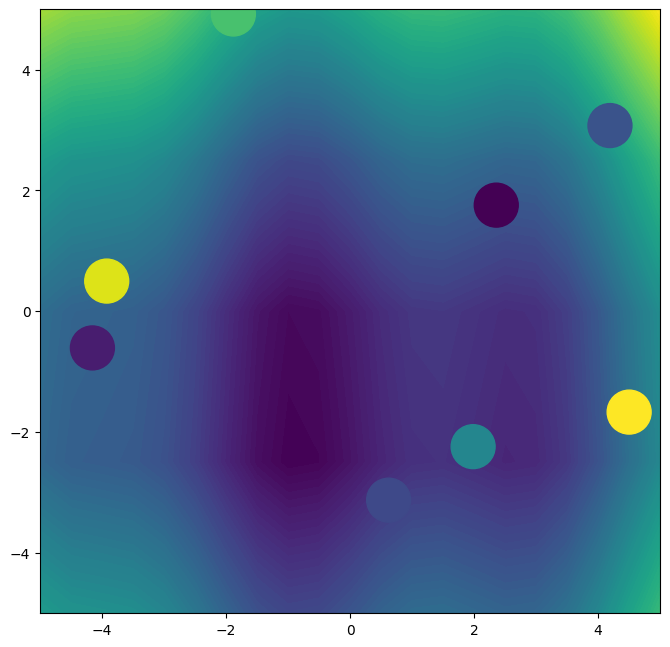

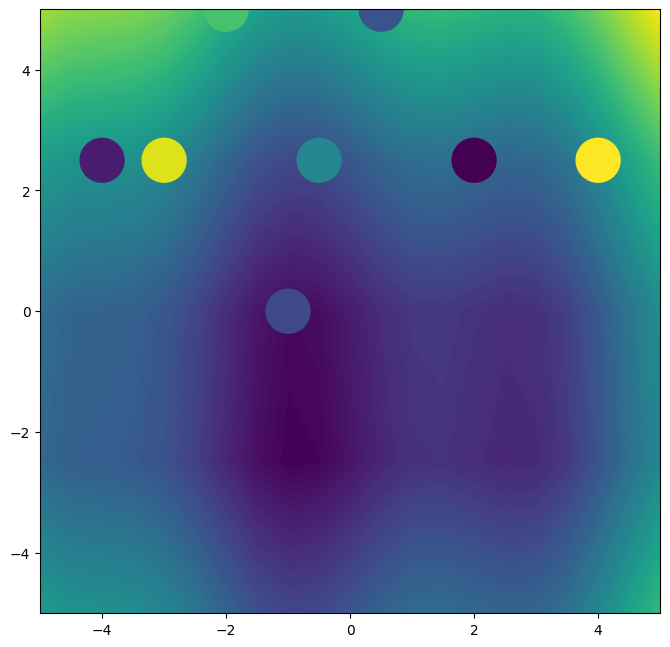

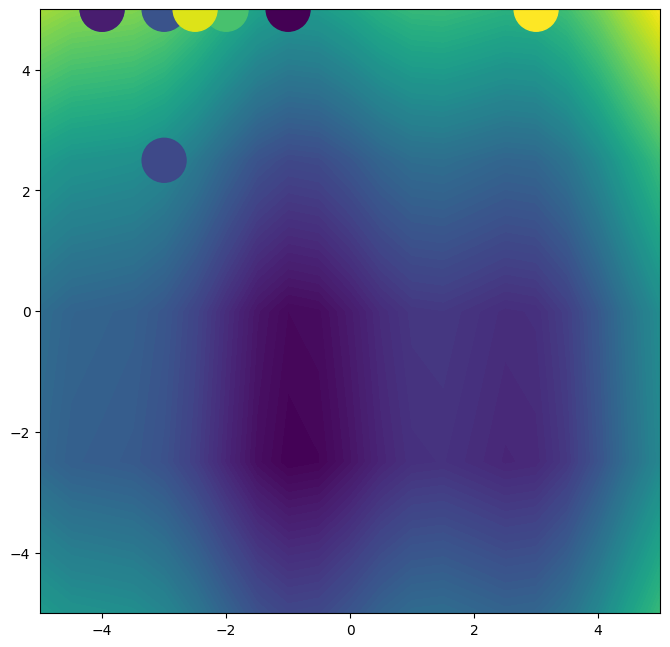

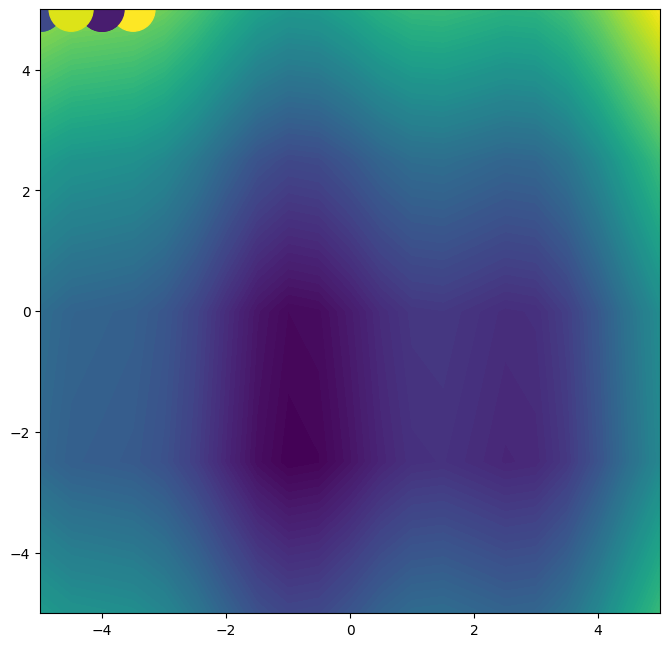

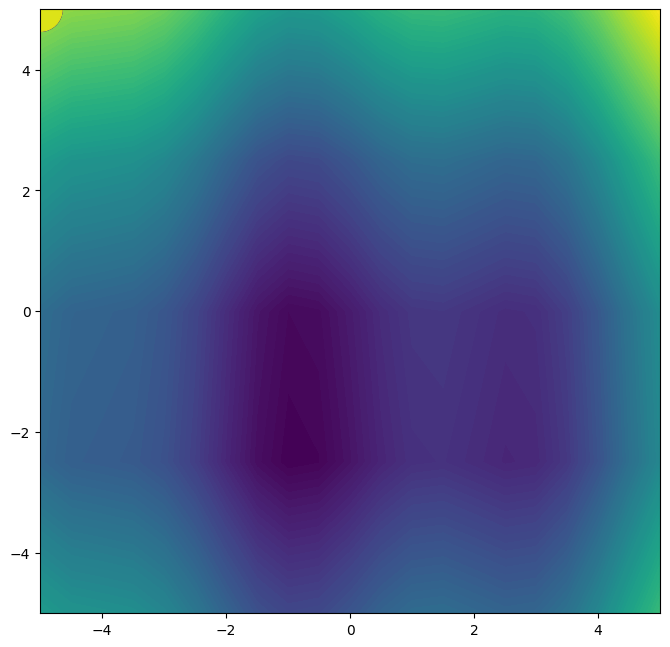

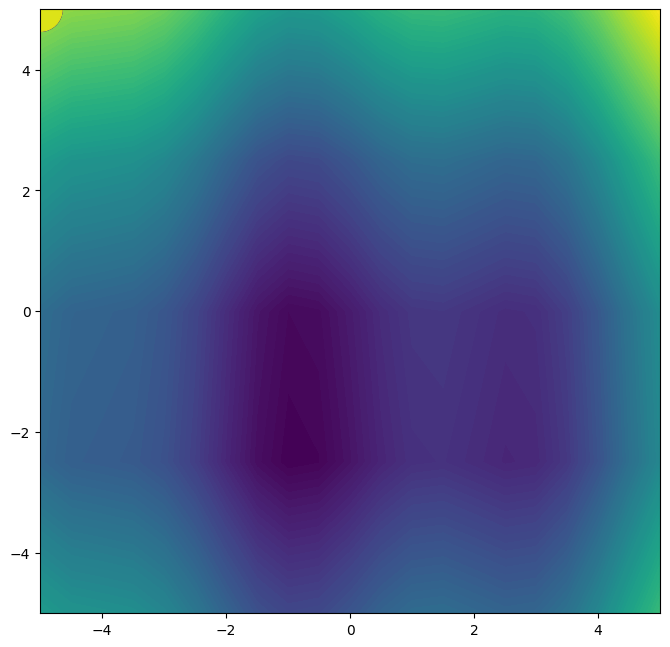

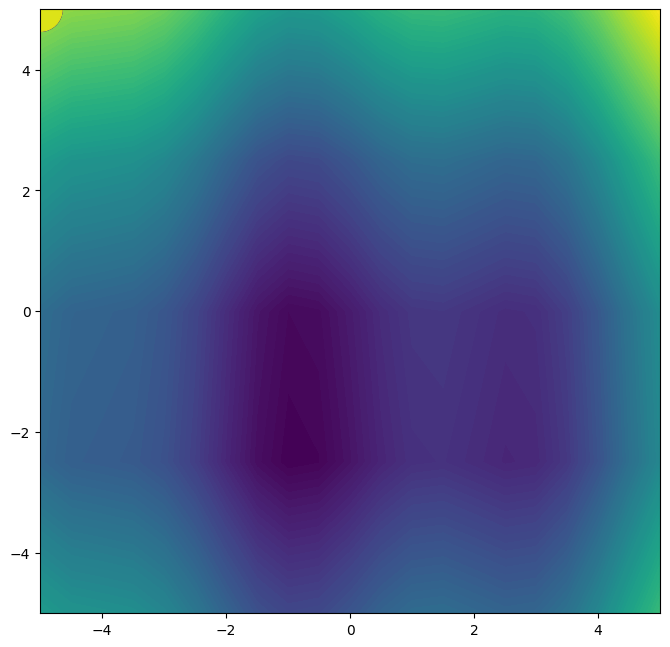

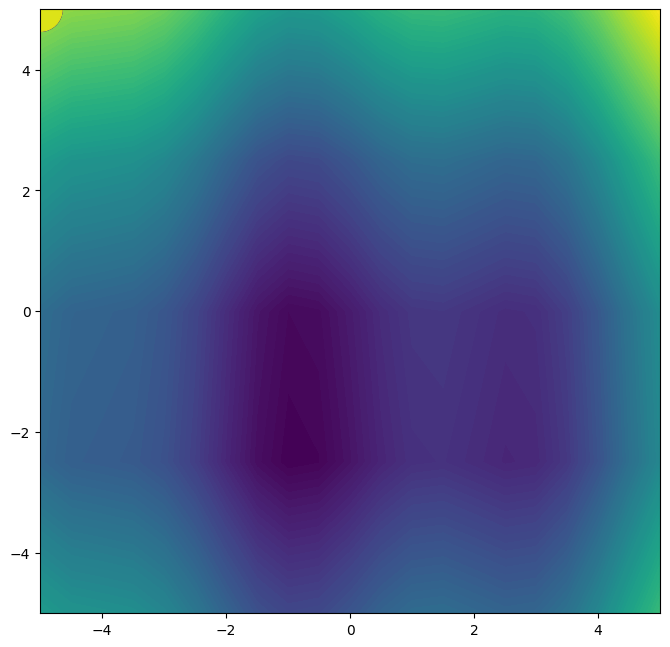

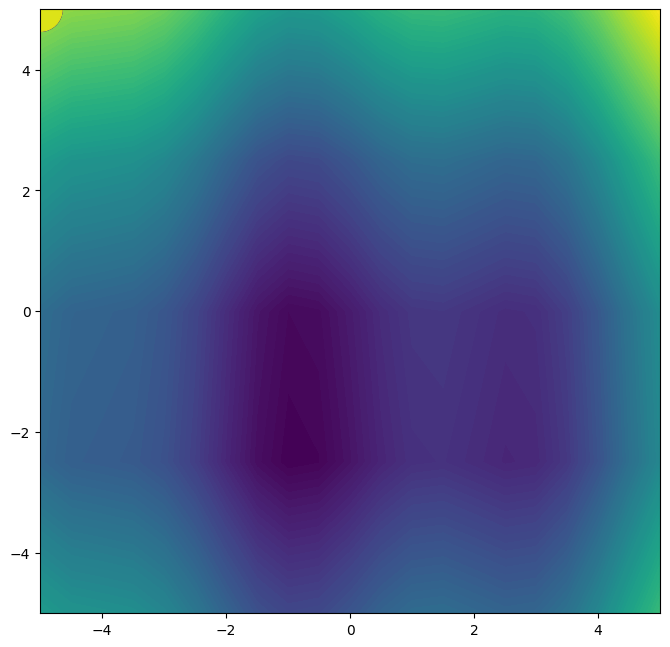

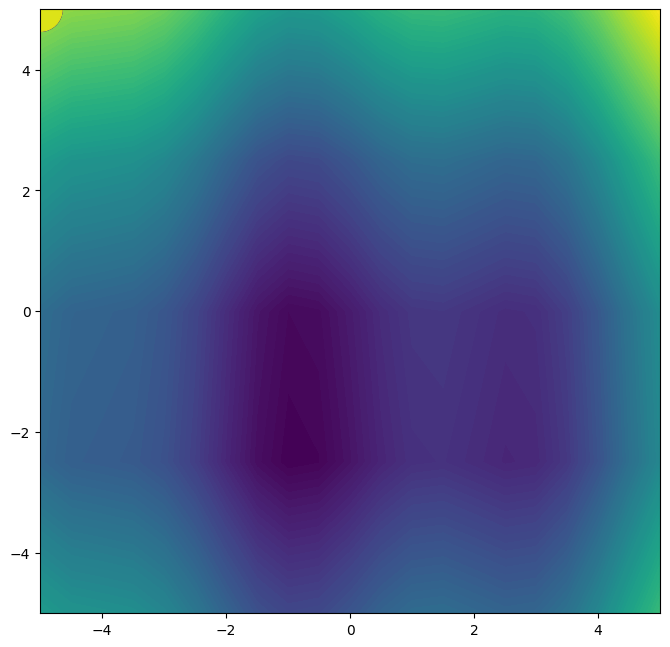

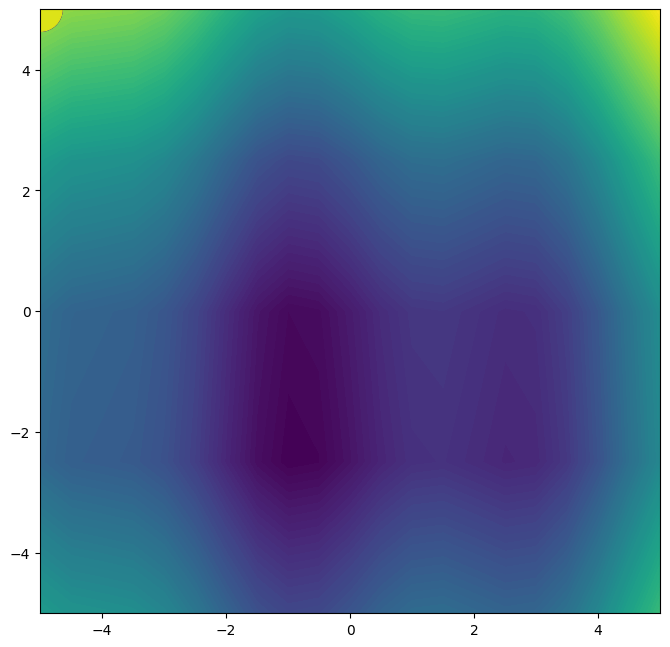

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jan 12 02:06:58 2023

@author: mikol
"""

#https://towardsdatascience.com/particle-swarm-optimization-visually-explained-46289eeb2e14

import matplotlib.pyplot as plt
import numpy as np
import random

import matplotlib
import os

path = "G:\\Mój dysk\\PNaF\\Diamentowy_Grant(2017-2021)\\Swimming_caterpillars_evolution\\wyniki\\symulacja_PSO\\"

x_min = -5
x_max = 5
x_delta = 0.5
x_nr = int(1+(x_max-x_min)/x_delta)

y_min = -5
y_max = 5
y_delta = 2.5
y_nr = int(1+(y_max-y_min)/y_delta)

x_space = np.linspace(x_min, x_max, x_nr)
y_space = np.linspace(y_min, y_max, y_nr)

individuals_per_generation = 8

caterpillar_c1 = caterpillar_c2 = 1

iterations_max = 10

#inertia
w = 0.8

def criterion(a):
    return max(a)

def fitness_function(x,y):
    result = x**2 + (y+1)**2 - 5*np.cos(1.5*x + 1.5) - 3*np.cos(2*y - 1.5)
    return result

class caterpillar:
    x = 0
    y = 0
    vx = 0
    vy = 0
    x_best = 0
    y_best = 0
    c1 = caterpillar_c1
    c2 = caterpillar_c2
    fitness = 0
    def __init__(self, x=2*x_max, y=2*y_max, vx = 2*x_max, vy = 2*y_max):
        if x == 2*x_max:
            x_new = random.uniform(x_min, x_max)
            self.x = self.x_best = min(x_space, key=lambda x:abs(x-x_new))

            self.vx = random.uniform(-1, 1)
        else:
            self.x = self.x_best = x
        if y == 2*y_max:
            y_new = random.uniform(y_min, y_max)
            self.y = self.y_best = min(y_space, key=lambda x:abs(x-y_new))
            self.vy = random.uniform(-1, 1)
        else:
            self.y = self.y_best = y
        self.fitness = fitness_function(self.x, self.y)

    def change_genes(self, x, y, vx, vy):
        old_fitness = self.fitness
        x_new = x
        y_new = y
        vx_new = vx
        vy_new = -vy
        if x_new > x_max:
            x_new = x_max
            vx_new = -vx_new
        if x_new < x_min:
            x_new = x_min
            vx_new = -vx_new
        if y_new > y_max:
            y_new = y_max
            vy_new = -vy_new
        if y_new < y_min:
            y_new = y_min
            vy_new = -vy_new
        # while x_new > x_max:
        #     x_new = x_new - x_max + x_min
        # while x_new < x_min:
        #     x_new = x_new + x_max - x_min
        # while y_new > y_max:
        #     y_new = y_new - y_max + y_min
        # while y_new < y_min:
        #     y_new = y_new + y_max - y_min

        self.x = x_new
        self.y = y_new
        self.fitness = fitness_function(self.x, self.y)
        self.vx = vx
        self.vy = vy
        if criterion([self.fitness, old_fitness]) == self.fitness:
            self.x_best = x_new
            self.y_best = y_new

    def get_parameters(self):
        return self.x, self.y, self.vx, self.vy

    def step(self,x_best_global, y_best_global):
        r1 = random.uniform(0, 1)
        r2 = random.uniform(0, 1)
        vx_new = w*self.vx + self.c1*r1*(self.x_best-self.x) + self.c2*r2*(x_best_global-self.x)
        x_new = self.x + vx_new
        x_new = min(x_space, key=lambda x:abs(x-x_new))

        r1 = random.uniform(0, 1)
        r2 = random.uniform(0, 1)
        vy_new = w*self.vy + self.c1*r1*(self.y_best-self.y) + self.c2*r2*(y_best_global-self.y)
        y_new = self.y + vy_new
        y_new = min(y_space, key=lambda x:abs(x-y_new))

        self.change_genes(x_new, y_new, vx_new, vy_new)

parameters_list = [(2.357537695351672, 1.7572290618155275, -0.21389383959837371, 0.28239374438064035), (-1.882149272409598, 4.921968677638329, -0.3520994972869339, -0.3295403062701566), (4.191280804430399, 3.074814862684132, -0.29870628549126643, 0.008944520809370582), (1.9844753664175618, -2.2412986816529323, -0.49133081059110495, 0.1414175882727381), (4.5008056112953, -1.669292157984339, 0.4278348181734595, -0.25981130100524374), (-4.156252146316527, -0.6066473600946818, -0.3856535929323125, -0.15002456936213582), (0.6213172378390555, -3.127002965292751, -0.12799228635233884, 0.27951050779144115), (-3.925374536633821, 0.49986097954395703, 0.24690613166937037, 0.0825131640648129)]

# =============================================================================
# caterpillar_list = [caterpillar() for i in range(individuals_per_generation)]
# parameters_list = []
# for cater in caterpillar_list:
#     parameters_list.append(cater.get_parameters())
# print(parameters_list)
# =============================================================================


caterpillar_list = [caterpillar(parameters_list[i][0],parameters_list[i][1],parameters_list[i][2],parameters_list[i][3]) for i in range(len(parameters_list))]

parameters_list_x = [parameters_list[i][0] for i in range(len(parameters_list))]
parameters_list_y = [parameters_list[i][1] for i in range(len(parameters_list))]


z = np.array([fitness_function(x,y) for y in y_space for x in x_space])

Z = z.reshape(y_nr, x_nr)
#plt.imshow(Z, interpolation='bilinear')
plt.figure(figsize=(8, 8), dpi=100)
plt.contourf(x_space,y_space,Z,100)
colors = np.random.rand(len(caterpillar_list))
plt.scatter(parameters_list_x, parameters_list_y, marker='o', c=colors, s=1000)
plt.show()
plt.close()

def get_fitness_function(x,y, Z):
    result = Z[np.where(x_space == x)[0][0]][np.where(y_space == x)[0][0]]
    return result

#criterion
cater_max_global = max(caterpillar_list, key=lambda x: x.fitness)
position_max_global = [cater_max_global.x, cater_max_global.y]
fitness_max_global = cater_max_global.fitness

position_max_global_new = position_max_global
fitness_max_global_new = fitness_max_global

for iterations in range (iterations_max):
    w = (0.4/iterations_max**2) * (iterations - iterations_max) ** 2 + 0.4
    caterpillar_c1 = -2 * iterations / iterations_max + 2.5
    caterpillar_c2 = 2 * iterations / iterations_max + 0.5

    parameters_list_x = np.array([])
    parameters_list_y = np.array([])
    for cater in caterpillar_list:
        cater.step(position_max_global[0], position_max_global[1])
        parameters_list_x = np.append(parameters_list_x, cater.x)
        parameters_list_y = np.append(parameters_list_y, cater.y)
        if criterion([cater.fitness, fitness_max_global_new]) == cater.fitness:
            fitness_max_global_new = cater.fitness
            position_max_global_new[0] = cater.x
            position_max_global_new[1] = cater.y
    fitness_max_global = fitness_max_global_new
    position_max_global = position_max_global_new

    plt.figure(figsize=(8, 8), dpi=100)
    plt.xlim([x_min, x_max])
    plt.ylim([y_min, y_max])
    plt.contourf(x_space,y_space,Z,100)
    plt.scatter(parameters_list_x, parameters_list_y, marker='o', c=colors, s=1000)
    plt.show()
    plt.close()

